### Part 1: Data Cleaning and Missing Data Treatment

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
import warnings

# Ignore FutureWarning and RuntimeWarning from statsmodels module
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# Import and ignore ConvergenceWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# General warnings filter
warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
# Load the dataset
df = pd.read_csv('D:/!!!Astari at UChicago/04 Summer 2024/Time Series Analysis/Final Project/HDR23-24.csv', encoding='ISO-8859-1')

# Filter the dataframe for the middle eastern countries
middle_east_countries = ['BHR', 'CYP', 'EGY', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUR', 'ARE', 'YEM']
df_me = df[df['iso3'].isin(middle_east_countries)]

# Select the columns for HDI from 1990 to 2022
columns_to_select = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1990, 2023)]
df_me_hdi = df_me[columns_to_select]

# Print the dataset
print(df_me_hdi)

    iso3                     country  hdi_1990  hdi_1991  hdi_1992  hdi_1993  \
12   BHR                     Bahrain     0.733     0.727     0.727     0.732   
44   CYP                      Cyprus     0.733     0.737     0.746     0.752   
51   EGY                       Egypt     0.567     0.574     0.580     0.587   
79   IRN  Iran (Islamic Republic of)     0.613     0.631     0.638     0.644   
80   IRQ                        Iraq     0.497     0.471     0.502     0.524   
82   ISR                      Israel     0.781     0.786     0.791     0.797   
86   JOR                      Jordan     0.622     0.629     0.643     0.648   
92   KWT                      Kuwait     0.698     0.687     0.697     0.703   
96   LBN                     Lebanon       NaN       NaN       NaN       NaN   
131  OMN                        Oman       NaN       NaN       NaN       NaN   
134  PSE         Palestine, State of       NaN       NaN       NaN       NaN   
142  QAT                       Qatar    

In [8]:
# Check for missing values
missing_values = df_me_hdi.isnull().sum()

# Calculate summary statistics
summary_statistics = df_me_hdi.describe()

# Display missing values and summary statistics
print("Missing Values:\n", missing_values)
print("\nSummary Statistics:\n", summary_statistics)

Missing Values:
 iso3        0
country     0
hdi_1990    3
hdi_1991    3
hdi_1992    3
hdi_1993    3
hdi_1994    3
hdi_1995    3
hdi_1996    3
hdi_1997    3
hdi_1998    3
hdi_1999    3
hdi_2000    2
hdi_2001    2
hdi_2002    2
hdi_2003    2
hdi_2004    1
hdi_2005    0
hdi_2006    0
hdi_2007    0
hdi_2008    0
hdi_2009    0
hdi_2010    0
hdi_2011    0
hdi_2012    0
hdi_2013    0
hdi_2014    0
hdi_2015    0
hdi_2016    0
hdi_2017    0
hdi_2018    0
hdi_2019    0
hdi_2020    0
hdi_2021    0
hdi_2022    0
dtype: int64

Summary Statistics:
         hdi_1990   hdi_1991   hdi_1992   hdi_1993   hdi_1994   hdi_1995  \
count  14.000000  14.000000  14.000000  14.000000  14.000000  14.000000   
mean    0.638714   0.640714   0.649000   0.655857   0.661714   0.668071   
std     0.117643   0.119336   0.116327   0.115075   0.116759   0.117988   
min     0.357000   0.361000   0.368000   0.374000   0.378000   0.389000   
25%     0.574750   0.581000   0.587000   0.594000   0.599500   0.606500   
50%     

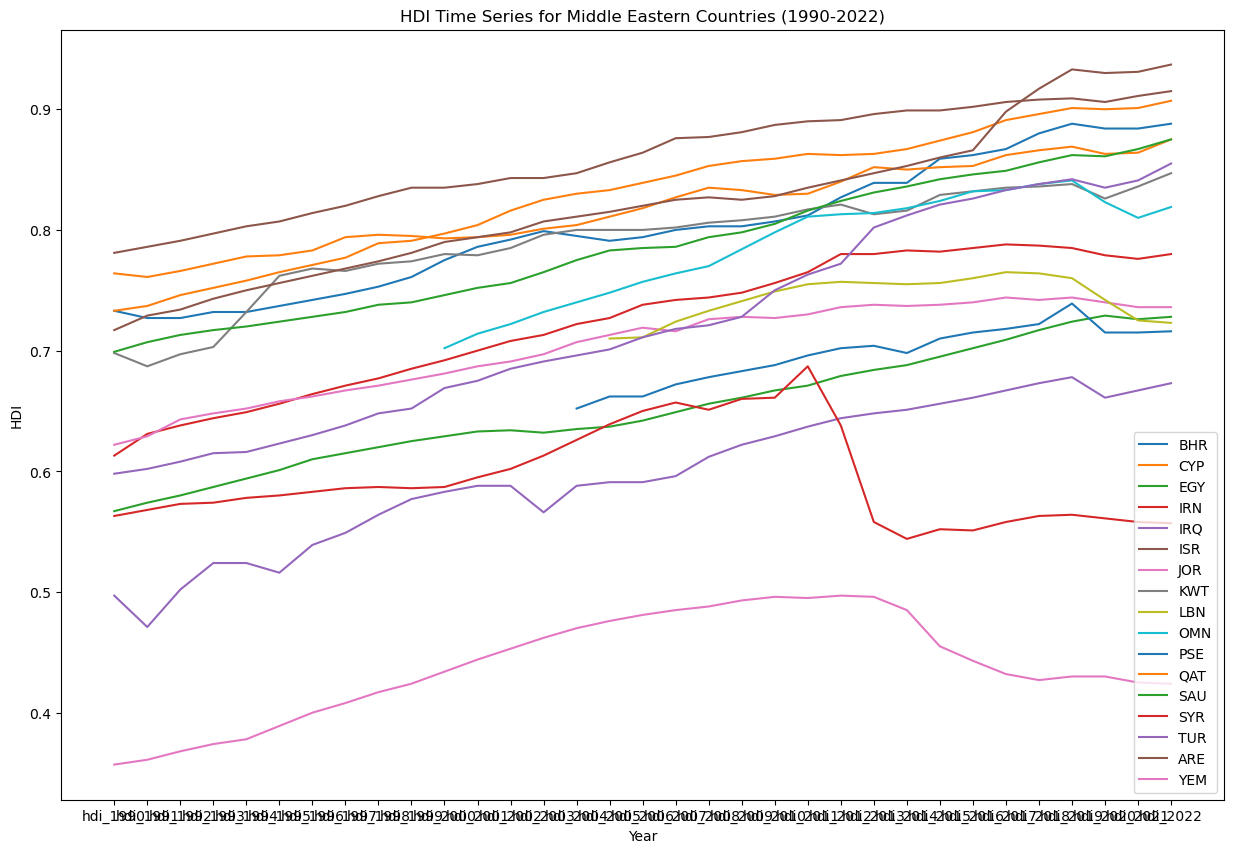

In [14]:
# Visualize the data through line plots
plt.figure(figsize=(15, 10))
for country in middle_east_countries:
    plt.plot(df_me_hdi[df_me_hdi['iso3'] == country].iloc[:, 2:].transpose(), label=country)
plt.title('HDI Time Series for Middle Eastern Countries (1990-2022)')
plt.xlabel('Year')
plt.ylabel('HDI')
plt.legend(loc='best')
plt.show()

In [17]:
# Make a copy and infer data types before handling interpolating
df_me_hdi_copy = df_me_hdi.copy()
df_me_hdi_copy = df_me_hdi_copy.infer_objects()
df_me_hdi_copy.interpolate(method='linear', inplace=True)

### Part 2. Handling Missing Data using Interpolation Method

In [18]:
# Check for remaining missing values
mv_interp = df_me_hdi_copy.isnull().sum()
print("Missing Values After Interpolation:\n", mv_interp)

Missing Values After Interpolation:
 iso3        0
country     0
hdi_1990    0
hdi_1991    0
hdi_1992    0
hdi_1993    0
hdi_1994    0
hdi_1995    0
hdi_1996    0
hdi_1997    0
hdi_1998    0
hdi_1999    0
hdi_2000    0
hdi_2001    0
hdi_2002    0
hdi_2003    0
hdi_2004    0
hdi_2005    0
hdi_2006    0
hdi_2007    0
hdi_2008    0
hdi_2009    0
hdi_2010    0
hdi_2011    0
hdi_2012    0
hdi_2013    0
hdi_2014    0
hdi_2015    0
hdi_2016    0
hdi_2017    0
hdi_2018    0
hdi_2019    0
hdi_2020    0
hdi_2021    0
hdi_2022    0
dtype: int64


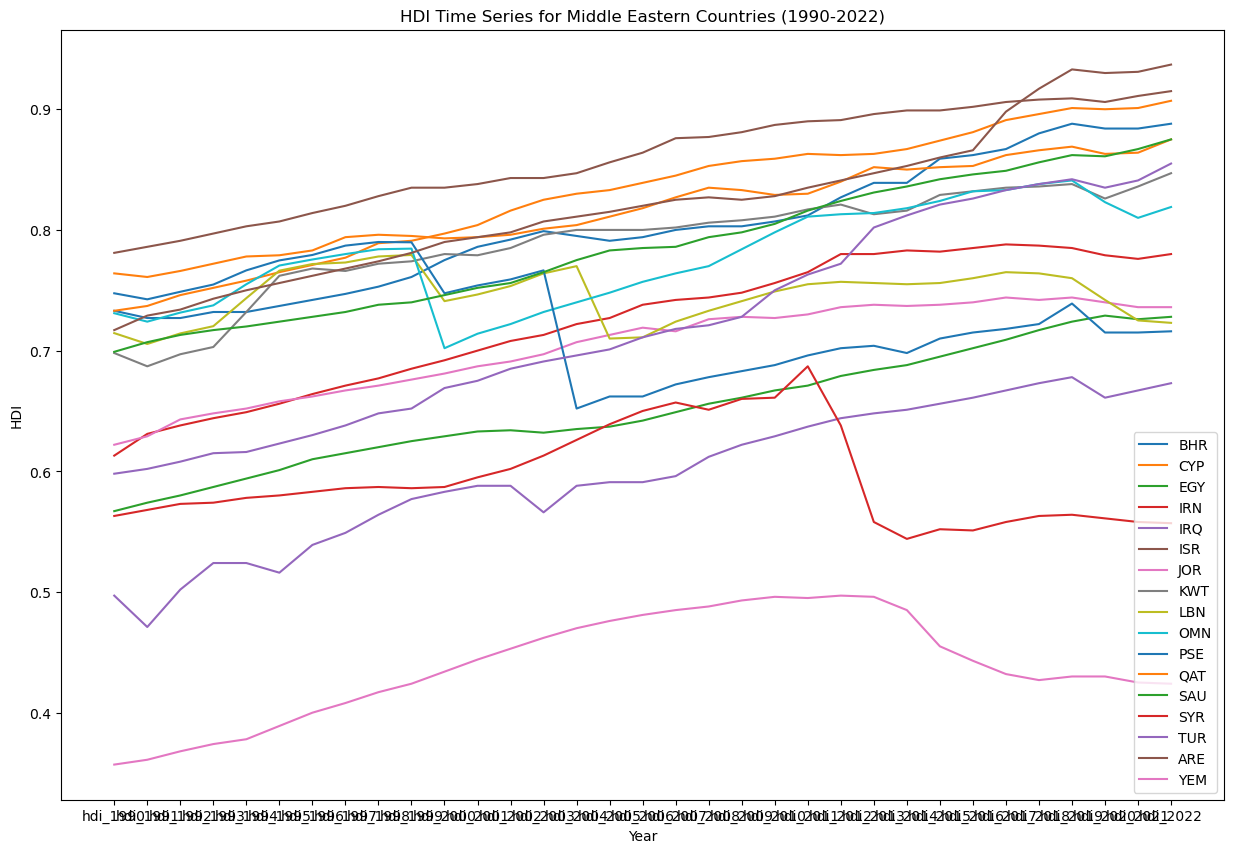

In [19]:
# EDA: Plot HDI time series for each country
plt.figure(figsize=(15, 10))
for country in middle_east_countries:
    plt.plot(df_me_hdi_copy[df_me_hdi_copy['iso3'] == country].iloc[:, 2:].transpose(), label=country)
plt.title('HDI Time Series for Middle Eastern Countries (1990-2022)')
plt.xlabel('Year')
plt.ylabel('HDI')
plt.legend(loc='best')
plt.show()

### Part 3. Perform ADF and KPSS Tests for All Middle Eastern Countries

In [31]:
# Perform ADF and KPSS tests for each country with interpretation and 0.05 significance level
adf_results = {}
kpss_results = {}

for country in middle_east_countries:
    country_data = df_me_hdi_copy[df_me_hdi_copy['iso3'] == country].iloc[:, 2:].transpose().squeeze()
    adf_result = adfuller(country_data)
    kpss_result = kpss(country_data, regression='c', nlags="auto")
    
    adf_p_value = adf_result[1]
    kpss_p_value = kpss_result[1]
    
    adf_stationarity = 'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'
    kpss_stationarity = 'Non-Stationary' if kpss_p_value < 0.05 else 'Stationary'
    
    adf_results[country] = {'ADF Statistic': adf_result[0], 'p-value': adf_p_value, 'Stationarity': adf_stationarity}
    kpss_results[country] = {'KPSS Statistic': kpss_result[0], 'p-value': kpss_p_value, 'Stationarity': kpss_stationarity}
    
    print(f"Country: {country}")
    print(f"ADF Test: Statistic = {adf_result[0]}, p-value = {adf_p_value}, Interpretation: {adf_stationarity}")
    print(f"KPSS Test: Statistic = {kpss_result[0]}, p-value = {kpss_p_value}, Interpretation: {kpss_stationarity}\n")

Country: BHR
ADF Test: Statistic = 0.47612644601045356, p-value = 0.9841291287656645, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.742789737673802, p-value = 0.01, Interpretation: Non-Stationary

Country: CYP
ADF Test: Statistic = -1.920083704145313, p-value = 0.322672881342974, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.7606617887768794, p-value = 0.01, Interpretation: Non-Stationary

Country: EGY
ADF Test: Statistic = -0.755997137667892, p-value = 0.8317072232353986, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.7637893802615547, p-value = 0.01, Interpretation: Non-Stationary

Country: IRN
ADF Test: Statistic = -4.1078874468129, p-value = 0.0009398546872439198, Interpretation: Stationary
KPSS Test: Statistic = 0.7399836589581804, p-value = 0.01, Interpretation: Non-Stationary

Country: IRQ
ADF Test: Statistic = -1.1835416279953621, p-value = 0.6806353167683505, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.9009206700283913, p-value = 0.01, 

Interpretation:

Based on the results of the ADF and KPSS tests, the next steps vary depending on the stationarity status of each country's time series. For countries where the time series is already stationary, such as Lebanon, we can directly fit a SARIMA model without applying any differencing. This means the historical HDI data for Lebanon can be used as is to forecast future values using the SARIMA model. This approach ensures that the inherent statistical properties of the time series are maintained, leading to more accurate and reliable forecasts.

For countries with non-stationary series, it is necessary to apply differencing to achieve stationarity. This involves using seasonal differencing (e.g., differencing by 12 months for yearly data) and potentially additional non-seasonal differencing. After applying the differencing, the ADF and KPSS tests should be conducted again to confirm the series has become stationary. Once stationarity is confirmed, a SARIMA model can be fitted to the transformed series. In cases where the ADF test indicates stationarity but the KPSS test does not, or vice versa, further differencing may be required to address any residual seasonality or trend components, ensuring the series is adequately prepared for modeling.

### Part 4: Forecasting HDI for Lebanon (Without Differencing) Using SARIMA

Best SARIMA model order: (0, 1, 0)
Best seasonal order: (0, 0, 0, 12)
Best AIC: -118.90651448232786
                               SARIMAX Results                                
Dep. Variable:                     96   No. Observations:                   24
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  60.453
Date:                Wed, 24 Jul 2024   AIC                           -118.907
Time:                        11:08:36   BIC                           -117.771
Sample:                    12-31-1990   HQIC                          -118.621
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   5.05e-05      6.044      0.000       0.000       0.000
Ljung-Box (L1) (Q):            

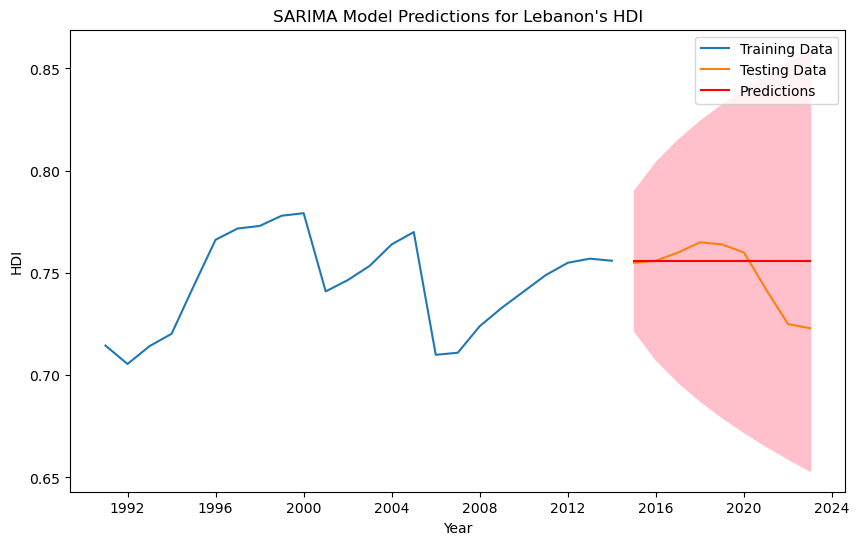

MAE: 0.011555555555555565
MSE: 0.0002693333333333338
MAPE: 1.5706269768499412
sMAPE: 1.5490921407813112
MASE: 1.0301464254952635


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.stattools import adfuller, kpss

# Extract Lebanon's HDI data
lebanon_data = df_me_hdi_copy[df_me_hdi_copy['iso3'] == 'LBN'].iloc[:, 2:].transpose().squeeze()
lebanon_data.index = pd.date_range(start='1990', periods=len(lebanon_data), freq='Y')

# Convert to pandas Series
lebanon_data = pd.Series(lebanon_data, index=lebanon_data.index)

# Split the data into training and testing sets
train_LBN, test_LBN = temporal_train_test_split(lebanon_data)


# Function to evaluate SARIMA models
def evaluate_sarima_model(train, order, seasonal_order):
    model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit.aic

# Evaluate SARIMA models with different parameters
best_aic = np.inf
best_order = None
best_seasonal_order = None
for p in range(3):
    for d in range(2):
        for q in range(3):
            for P in range(3):
                for D in range(2):
                    for Q in range(3):
                        try:
                            seasonal_order = (P, D, Q, 12)
                            aic = evaluate_sarima_model(train_LBN, (p, d, q), seasonal_order)
                            if aic < best_aic:
                                best_aic = aic
                                best_order = (p, d, q)
                                best_seasonal_order = seasonal_order
                        except:
                            continue

print(f'Best SARIMA model order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')
print(f'Best AIC: {best_aic}')

# Fit the best SARIMA model
best_model = sm.tsa.SARIMAX(train_LBN, order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit(disp=False)

# Display model summary
print(best_model_fit.summary())

# Predict future values
n_forecast = len(test_LBN)
predictions = best_model_fit.get_forecast(steps=n_forecast)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(train_LBN, label='Training Data')
plt.plot(test_LBN, label='Testing Data')
plt.plot(predicted_mean, label='Predictions', color='red')
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink')
plt.title('SARIMA Model Predictions for Lebanon\'s HDI')
plt.xlabel('Year')
plt.ylabel('HDI')
plt.legend()
plt.show()

# Error metrics
mae = mean_absolute_error(test_LBN, predicted_mean)
mse = mean_squared_error(test_LBN, predicted_mean)
mape = np.mean(np.abs((test_LBN - predicted_mean) / test_LBN)) * 100
smape = np.mean(2 * np.abs(predicted_mean - test_LBN) / (np.abs(test_LBN) + np.abs(predicted_mean))) * 100
mase = mae / mean_absolute_error(train_LBN[1:], train_LBN[:-1])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape}')
print(f'MASE: {mase}')

Interpretation: 

The SARIMA model results indicate that the best fit for Lebanon's HDI time series data is achieved with a model order of (0, 1, 0) and a seasonal order of (0, 0, 0, 12). This means that the model includes one order of non-seasonal differencing and no autoregressive or moving average components, both seasonally and non-seasonally. The low AIC value of -118.907 suggests that this model is well-suited for the data, given the parameters considered. The model summary also shows that the residuals appear to be normally distributed with no significant autocorrelation, as indicated by the Ljung-Box test p-value of 0.71, suggesting a good model fit.

The plot of the SARIMA model predictions shows that the model has been able to capture the general trend of the HDI values during the training period. However, the predictions for the testing period are relatively flat, indicating that the model expects the HDI to remain relatively stable in the near future. The confidence intervals, depicted by the shaded area, show increasing uncertainty over the forecast horizon, which is typical in time series forecasting. The actual testing data shows some fluctuations which the model's predictions do not fully capture, suggesting that while the model fits well in-sample, its forecasting ability might be limited by the simplicity of the chosen parameters.

The error metrics provide further insight into the model's performance. The Mean Absolute Error (MAE) of 0.0116 and Mean Squared Error (MSE) of 0.00026 are quite low, indicating that the model's predictions are close to the actual values on average. The Mean Absolute Percentage Error (MAPE) of 1.57% and Symmetric Mean Absolute Percentage Error (sMAPE) of 1.55% are also low, indicating good predictive accuracy. The Mean Absolute Scaled Error (MASE) of 1.03 suggests that the model's prediction accuracy is slightly better than a naive forecasting model, where the MASE value close to 1 indicates performance comparable to the naive model. Overall, the SARIMA model performs well in capturing the historical trend and making reasonable predictions, although there is room for improvement in forecasting future fluctuations.








### Part 2: First Differencing for the Rest of the Countries

In [50]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# Define the countries to exclude (Lebanon)
excluded_countries = ['LBN']

# Initialize dictionaries to store results
adf_results_diff = {}
kpss_results_diff = {}

# Apply first differencing and perform ADF and KPSS tests for the remaining countries
for country in middle_east_countries:
    if country in excluded_countries:
        continue
    
    country_data = df_me_hdi_copy[df_me_hdi_copy['iso3'] == country].iloc[:, 2:].transpose().squeeze()
    
    # First differencing
    country_data_diff = country_data.diff().dropna()
    
    # ADF Test
    adf_result = adfuller(country_data_diff)
    adf_p_value = adf_result[1]
    adf_stationarity = 'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'
    
    # KPSS Test
    kpss_result = kpss(country_data_diff, regression='c', nlags="auto")
    kpss_p_value = kpss_result[1]
    kpss_stationarity = 'Non-Stationary' if kpss_p_value < 0.05 else 'Stationary'
    
    # Store results
    adf_results_diff[country] = {'ADF Statistic': adf_result[0], 'p-value': adf_p_value, 'Stationarity': adf_stationarity}
    kpss_results_diff[country] = {'KPSS Statistic': kpss_result[0], 'p-value': kpss_p_value, 'Stationarity': kpss_stationarity}
    
    # Print results
    print(f"Country: {country} (First Differenced)")
    print(f"ADF Test: Statistic = {adf_result[0]}, p-value = {adf_p_value}, Interpretation: {adf_stationarity}")
    print(f"KPSS Test: Statistic = {kpss_result[0]}, p-value = {kpss_p_value}, Interpretation: {kpss_stationarity}\n")


Country: BHR (First Differenced)
ADF Test: Statistic = -4.675011954112891, p-value = 9.373457998960057e-05, Interpretation: Stationary
KPSS Test: Statistic = 0.1481531728237592, p-value = 0.1, Interpretation: Stationary

Country: CYP (First Differenced)
ADF Test: Statistic = -3.1988206987471153, p-value = 0.020053043367393435, Interpretation: Stationary
KPSS Test: Statistic = 0.3310677442707511, p-value = 0.1, Interpretation: Stationary

Country: EGY (First Differenced)
ADF Test: Statistic = -2.976921450234589, p-value = 0.037106580093275734, Interpretation: Stationary
KPSS Test: Statistic = 0.10893530730045171, p-value = 0.1, Interpretation: Stationary

Country: IRN (First Differenced)
ADF Test: Statistic = 0.35294809330011107, p-value = 0.9796474837844464, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.6300334750642385, p-value = 0.019906047721432864, Interpretation: Non-Stationary

Country: IRQ (First Differenced)
ADF Test: Statistic = -7.278550746129726, p-value = 1.521627

Interpretation:

The results of the first differencing followed by ADF and KPSS tests for the Middle Eastern countries, excluding Lebanon, show that most countries have become stationary with first differencing. Specifically, countries like Bahrain (BHR), Cyprus (CYP), Egypt (EGY), Iraq (IRQ), Israel (ISR), Oman (OMN), Palestine (PSE), Qatar (QAT), Saudi Arabia (SAU), Syria (SYR), Turkey (TUR), and UAE (ARE) all demonstrate stationarity based on both ADF and KPSS tests. However, Iran (IRN), Jordan (JOR), Kuwait (KWT), and Yemen (YEM) remain non-stationary even after first differencing according to at least one of the tests. For Iran, Jordan, and Yemen, both tests indicate non-stationarity, while for Kuwait, the ADF test suggests non-stationarity but the KPSS test indicates stationarity. These mixed results suggest that further differencing or other transformations might be required for these countries to achieve stationarity.

### Part 3. ACF and PACF Plot for BHR, CYP, EGY, IRQ, ISR, OMN, PSE, QAT, SAU, SYR, TUR, and ARE (First Difference)

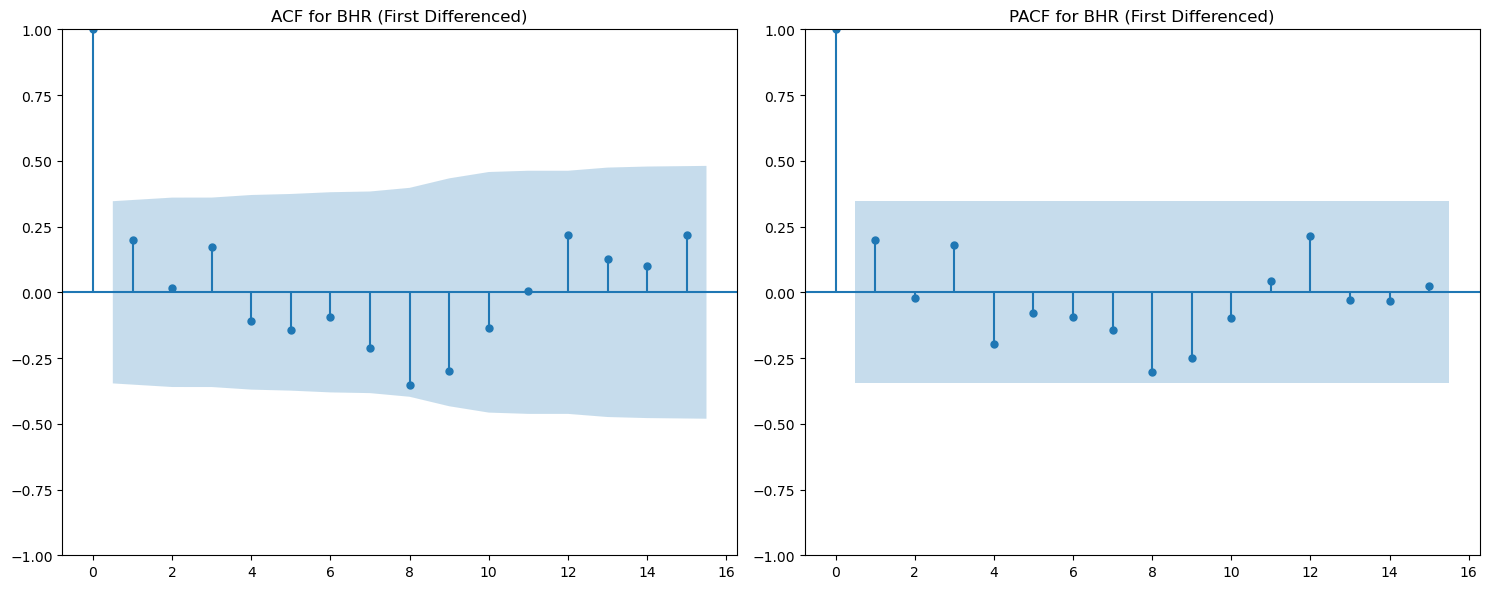

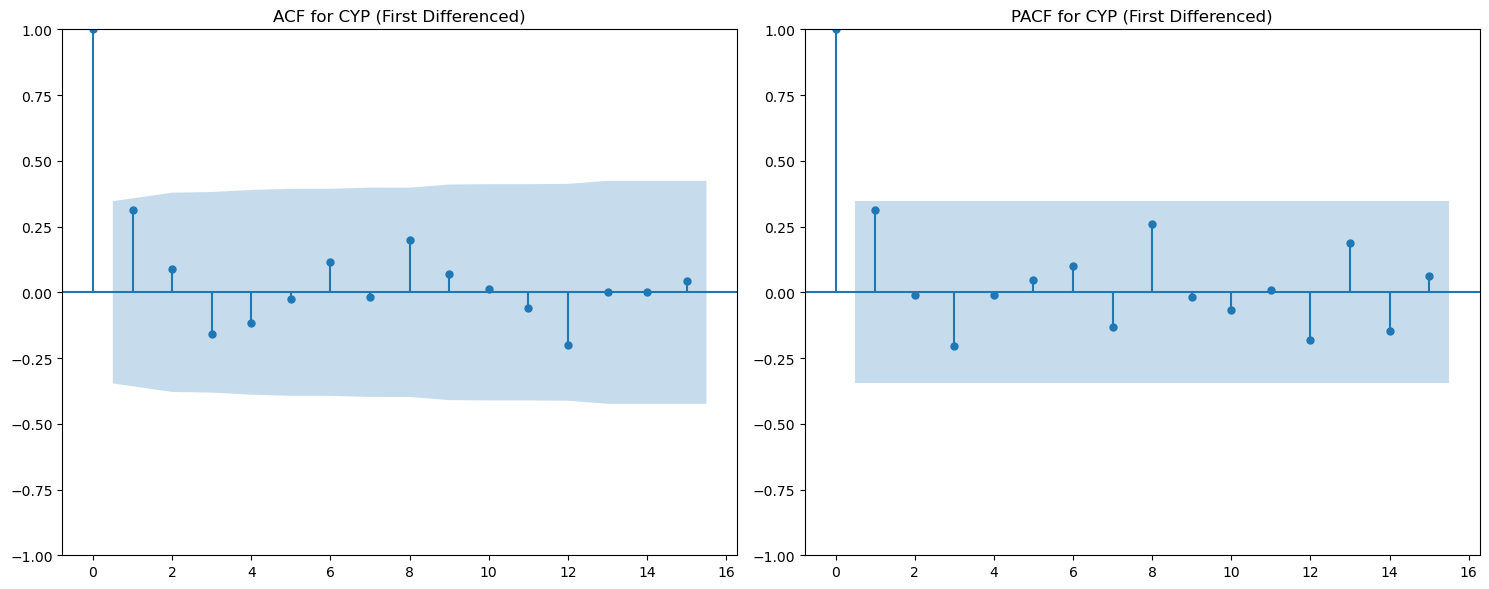

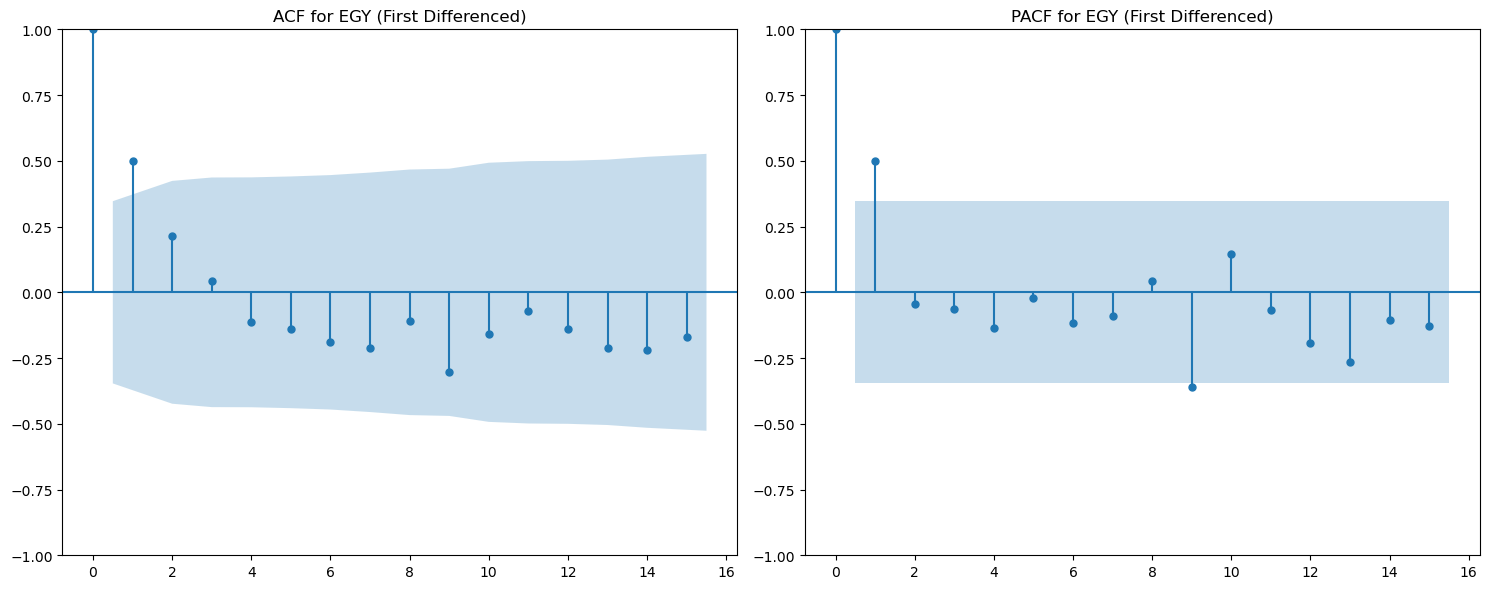

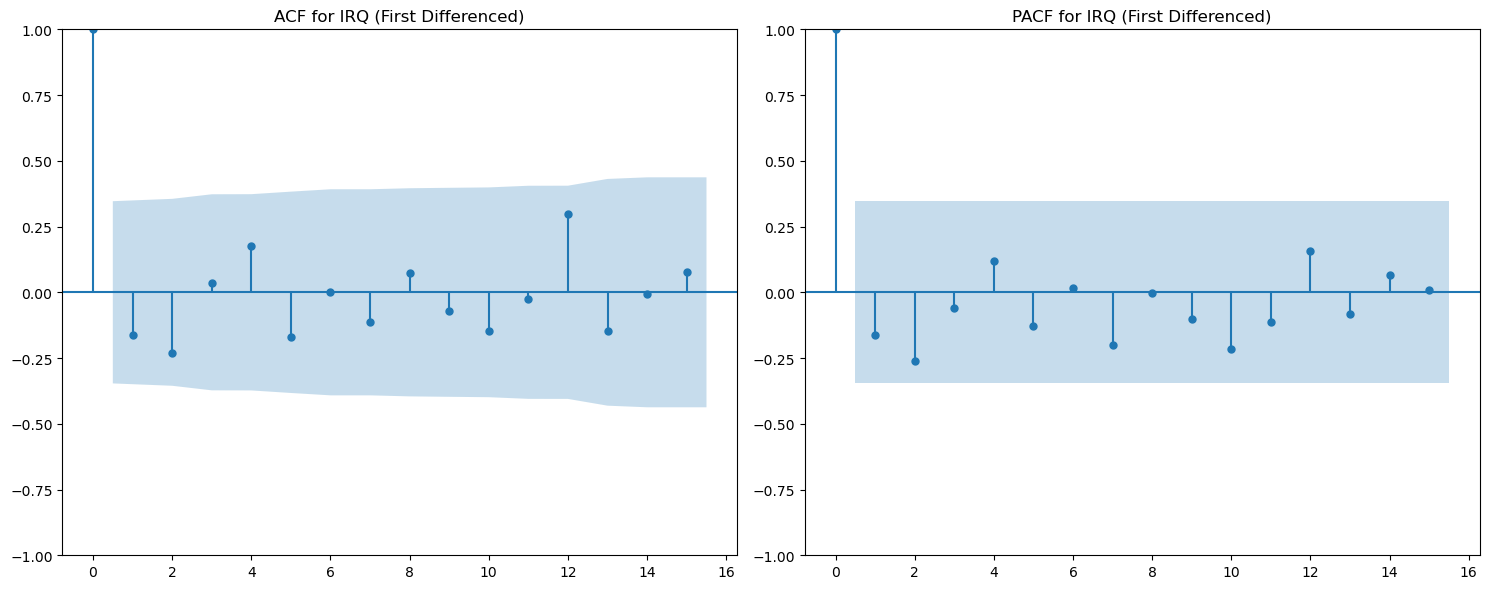

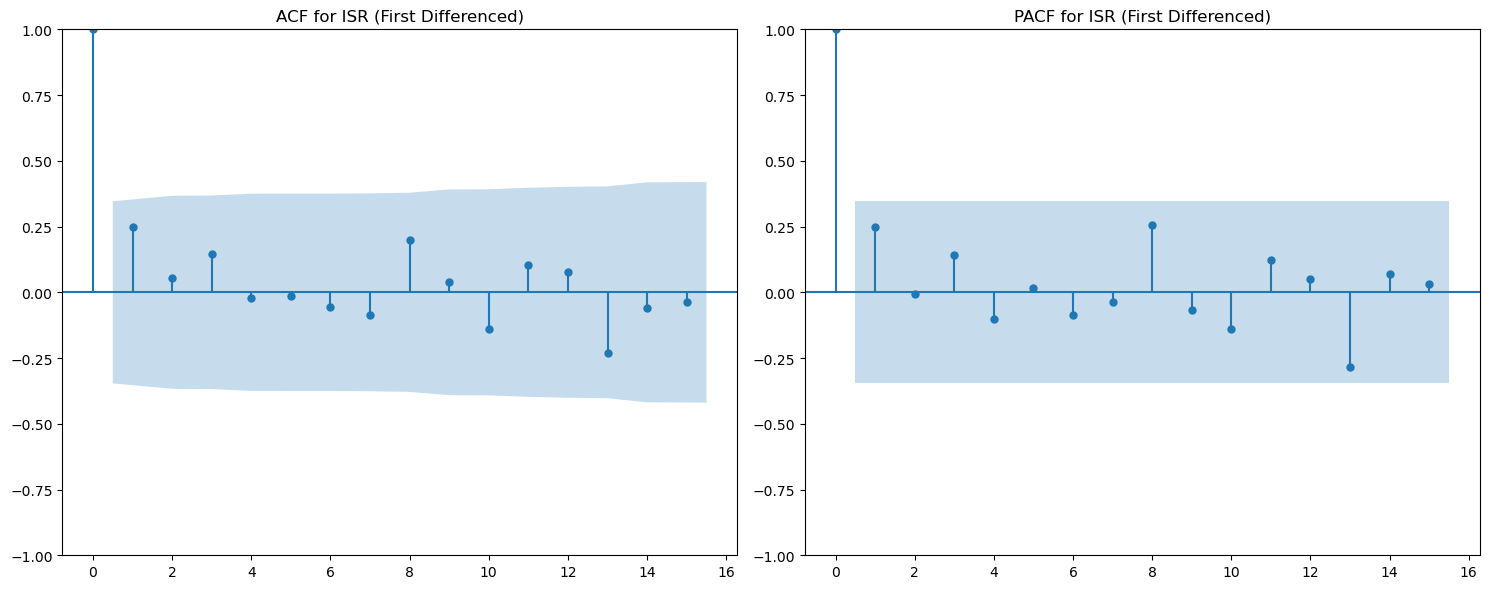

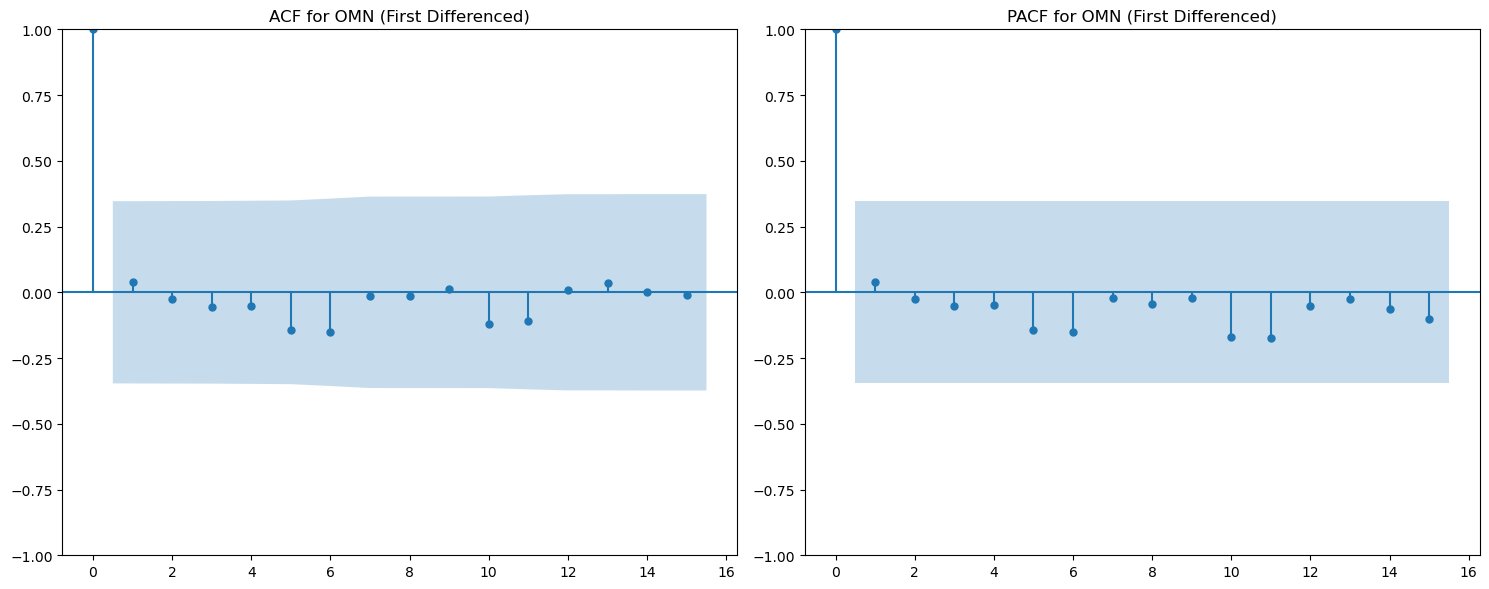

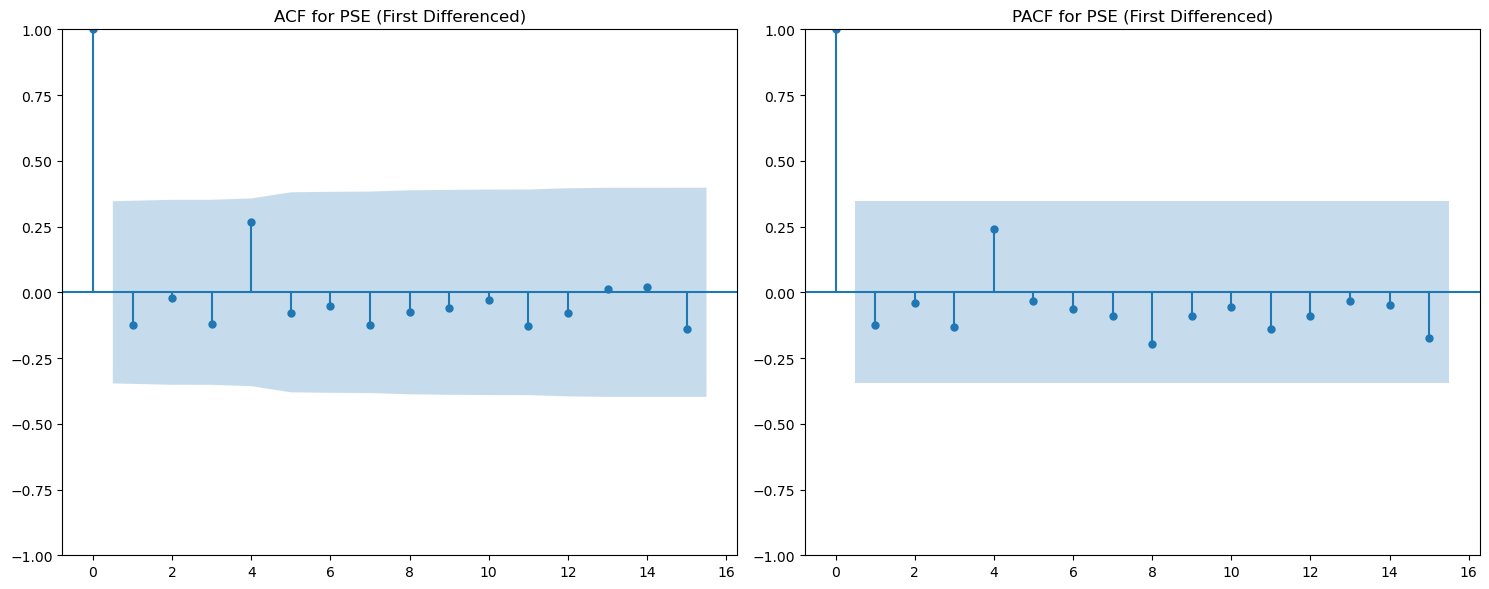

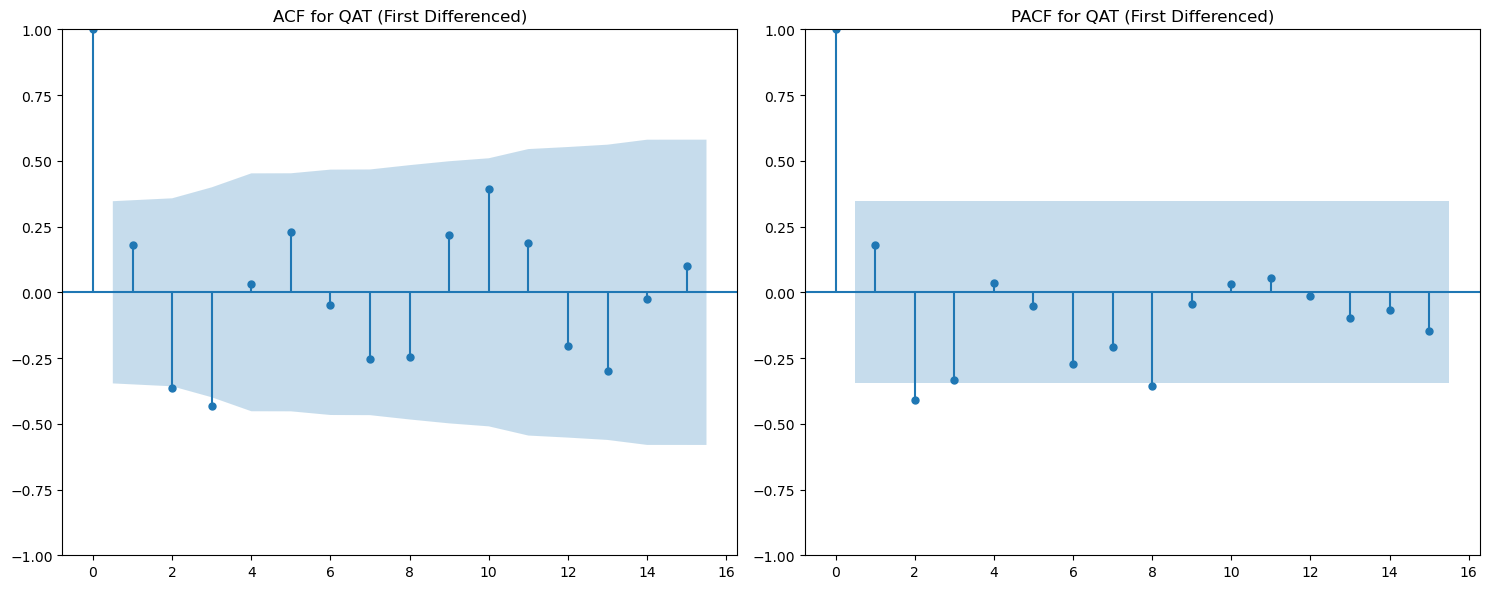

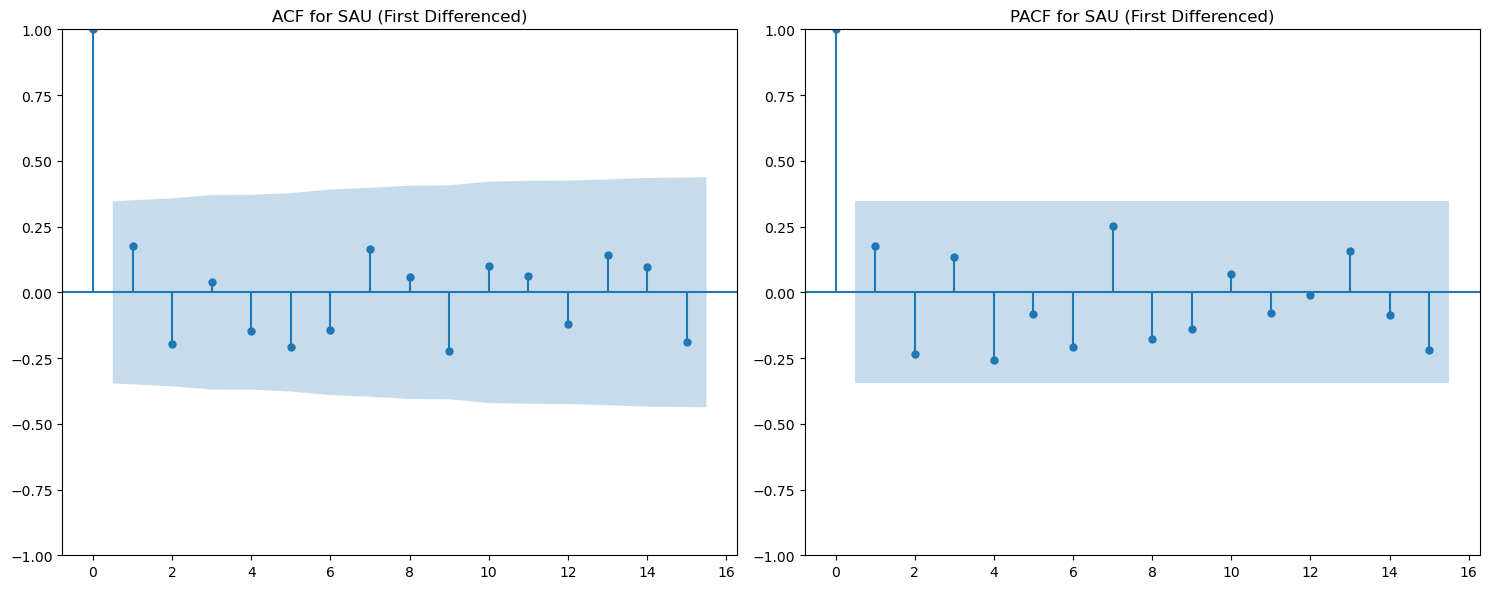

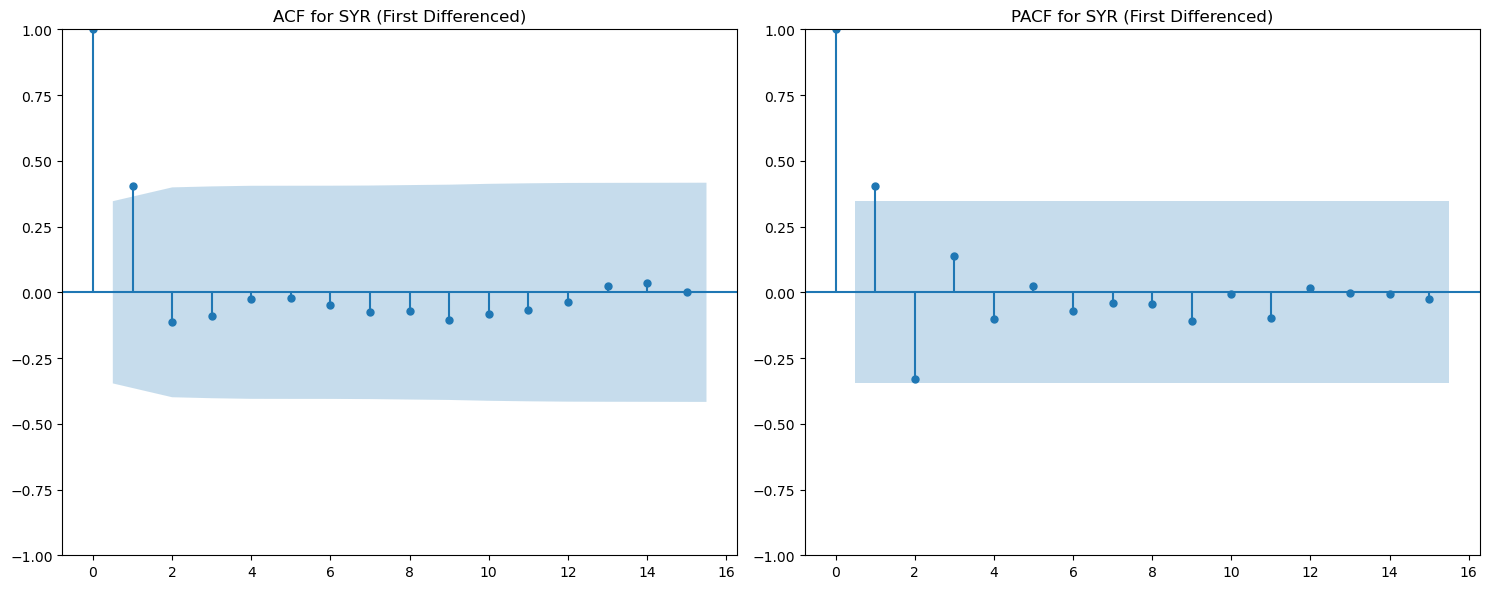

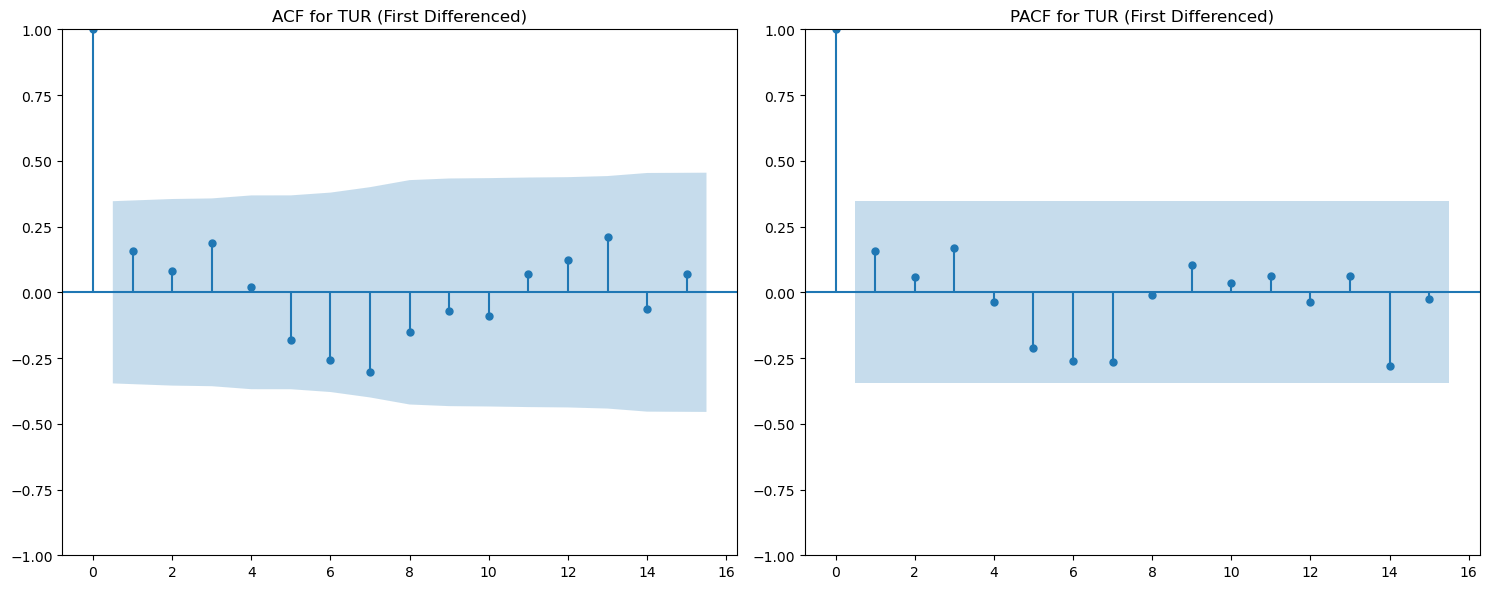

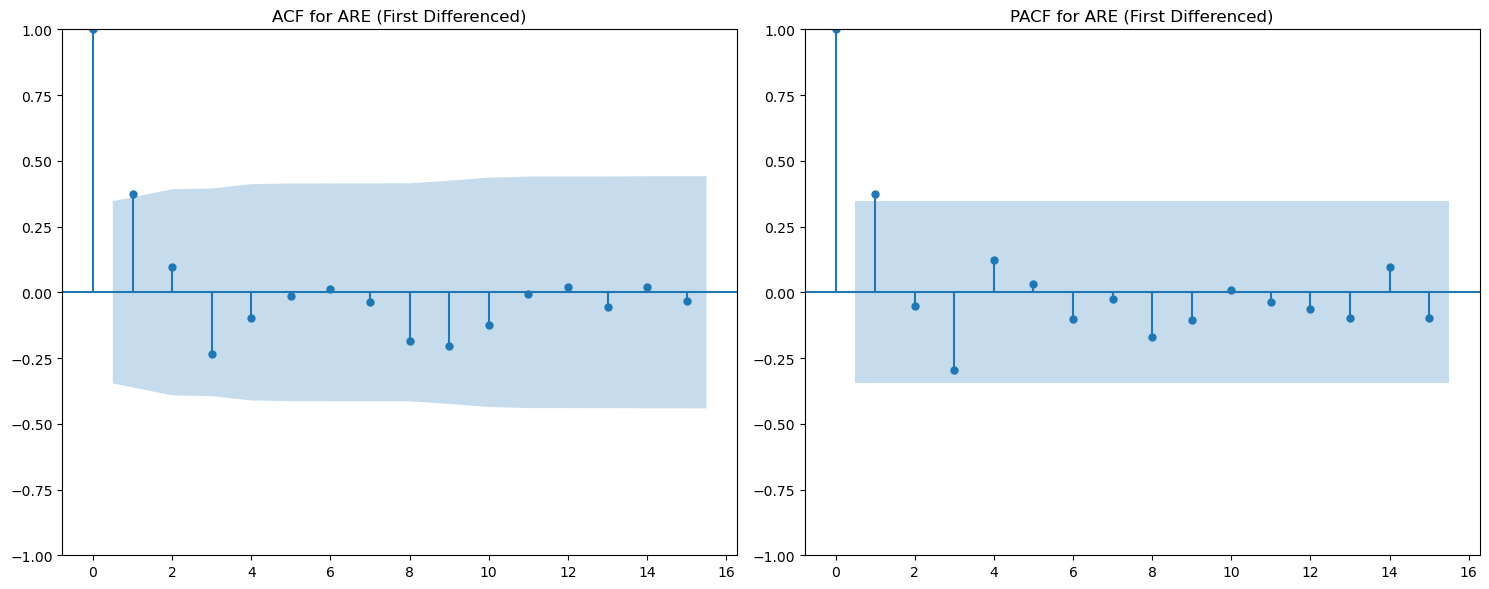

In [54]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# List of countries to plot ACF and PACF
countries_to_plot = ['BHR', 'CYP', 'EGY', 'IRQ', 'ISR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUR', 'ARE']

# Create ACF and PACF plots for the specified countries
for country in countries_to_plot:
    country_data_diff = df_me_hdi_copy[df_me_hdi_copy['iso3'] == country].iloc[:, 2:].transpose().squeeze().diff().dropna()
    nobs = len(country_data_diff)
    max_lags = min(20, nobs // 2 - 1)  # Set max_lags dynamically based on the sample size
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plot_acf(country_data_diff, lags=max_lags, ax=plt.gca())
    plt.title(f'ACF for {country} (First Differenced)')
    
    plt.subplot(1, 2, 2)
    plot_pacf(country_data_diff, lags=max_lags, ax=plt.gca())
    plt.title(f'PACF for {country} (First Differenced)')
    
    plt.tight_layout()
    plt.show()


Interpretation:

BHR, CYP, EGY
For Bahrain (BHR), Cyprus (CYP), and Egypt (EGY), the ACF plots show a rapid decline in autocorrelation values, indicating that the first differencing was effective in achieving stationarity. The PACF plots for these countries display a few significant spikes at the early lags, suggesting that an ARIMA model with a low order AR component (such as AR(1) or AR(2)) might be appropriate.

IRQ, ISR, OMN
For Iraq (IRQ), Israel (ISR), and Oman (OMN), the ACF plots also exhibit a quick drop-off, confirming stationarity. The PACF plots for these countries show significant spikes at lag 1 and 2, indicating the presence of AR terms. Specifically, IRQ has a significant spike at lag 1 in the PACF plot, suggesting an AR(1) model could be suitable.

PSE, QAT, SAU
The plots for Palestine (PSE), Qatar (QAT), and Saudi Arabia (SAU) reveal similar patterns. The ACF plots for these countries decline rapidly, which is indicative of stationarity after first differencing. The PACF plots exhibit significant spikes at early lags, suggesting that AR terms might be needed. For instance, PSE and QAT show spikes at lag 1 and 2 in the PACF plots, suggesting a possible AR(2) model.

SYR, TUR, ARE
Syria (SYR), Turkey (TUR), and the United Arab Emirates (ARE) show ACF plots that also drop off rapidly, indicating successful differencing. The PACF plots for these countries show significant spikes at the early lags, indicating potential AR terms. For example, TUR shows significant spikes at lag 1 in the PACF plot, suggesting an AR(1) model might be suitable.

### Part 4. Forecasting HDI of BHR, CYP, EGY, IRQ, ISR, OMN, PSE, QAT, SAU, SYR, TUR, and ARE using SARIMA (First Difference)

BHR - Best SARIMA model order: (1, 1, 0)
BHR - Best seasonal order: (0, 0, 0, 12)
BHR - Best AIC: -177.48545177803274
                               SARIMAX Results                                
Dep. Variable:                     12   No. Observations:                   24
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  90.743
Date:                Wed, 24 Jul 2024   AIC                           -177.485
Time:                        13:03:10   BIC                           -175.214
Sample:                    12-31-1990   HQIC                          -176.914
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7970      0.171      4.664      0.000       0.462       1.132
sigma2      2

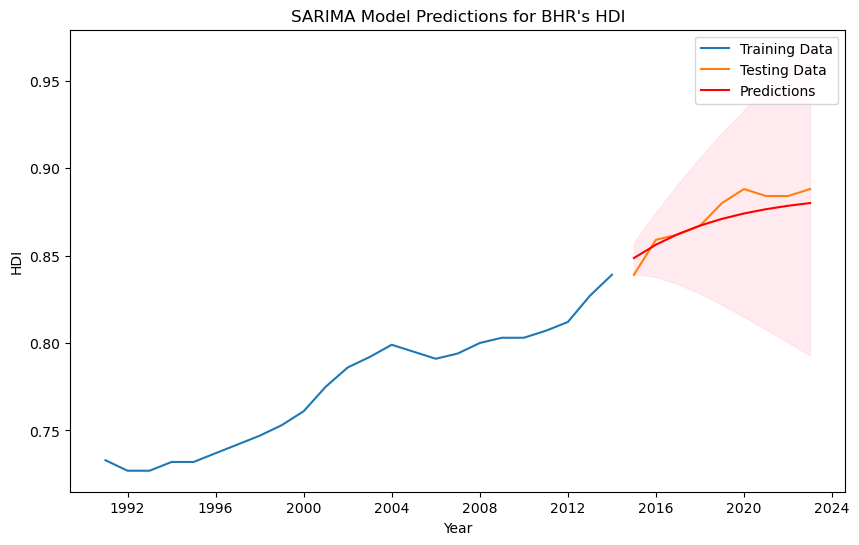

BHR - MAE: 0.006314226904300353
BHR - MSE: 5.863708849342589e-05
BHR - MAPE: 0.7211368131386273
BHR - sMAPE: 0.723529995711652
BHR - MASE: 1.0837852149172247


CYP - Best SARIMA model order: (1, 1, 1)
CYP - Best seasonal order: (0, 0, 0, 12)
CYP - Best AIC: -192.70592795791734
                               SARIMAX Results                                
Dep. Variable:                     44   No. Observations:                   24
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  99.353
Date:                Wed, 24 Jul 2024   AIC                           -192.706
Time:                        13:04:08   BIC                           -189.299
Sample:                    12-31-1990   HQIC                          -191.849
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

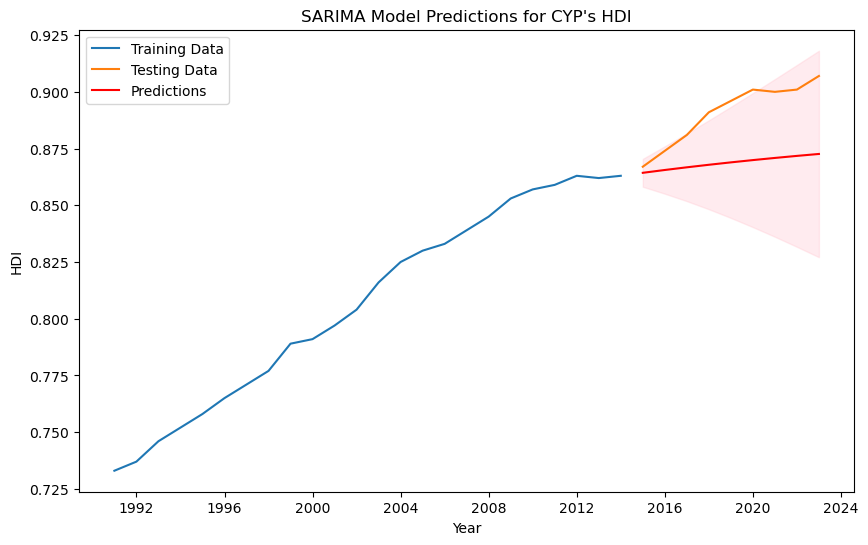

CYP - MAE: 0.022157843349464232
CYP - MSE: 0.0006001203461796998
CYP - MAPE: 2.4704180914281157
CYP - sMAPE: 2.5081279149352684
CYP - MASE: 3.8608363411945255


EGY - Best SARIMA model order: (2, 1, 0)
EGY - Best seasonal order: (0, 0, 0, 12)
EGY - Best AIC: -210.14030302386917
                               SARIMAX Results                                
Dep. Variable:                     51   No. Observations:                   24
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 108.070
Date:                Wed, 24 Jul 2024   AIC                           -210.140
Time:                        13:05:14   BIC                           -206.734
Sample:                    12-31-1990   HQIC                          -209.284
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

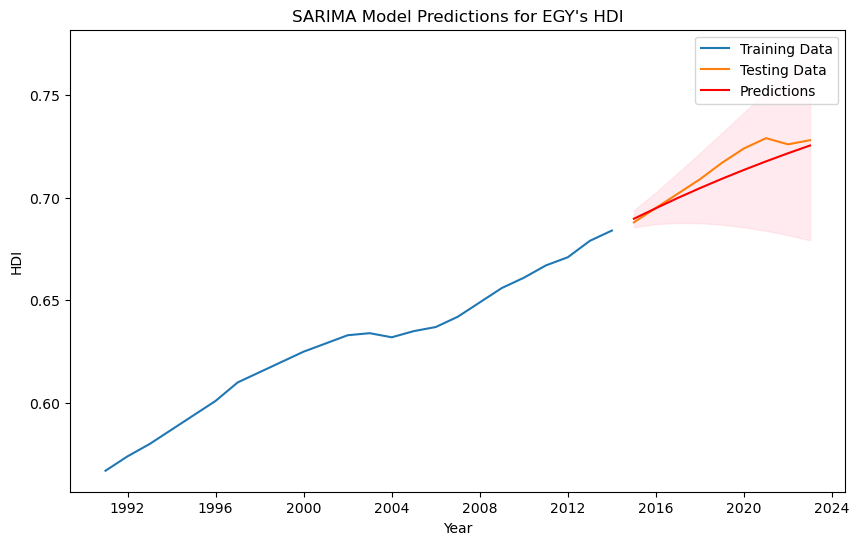

EGY - MAE: 0.004972988025490189
EGY - MSE: 3.881227314917234e-05
EGY - MAPE: 0.6903523888007232
EGY - sMAPE: 0.6940136061103713
EGY - MASE: 0.9452787155890434


IRQ - Best SARIMA model order: (0, 1, 0)
IRQ - Best seasonal order: (1, 0, 0, 12)
IRQ - Best AIC: -139.11112006744227
                                     SARIMAX Results                                      
Dep. Variable:                                 80   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  71.556
Date:                            Wed, 24 Jul 2024   AIC                           -139.111
Time:                                    13:06:22   BIC                           -136.840
Sample:                                12-31-1990   HQIC                          -138.540
                                     - 12-31-2013                                         
Covariance Type:                              opg                                   

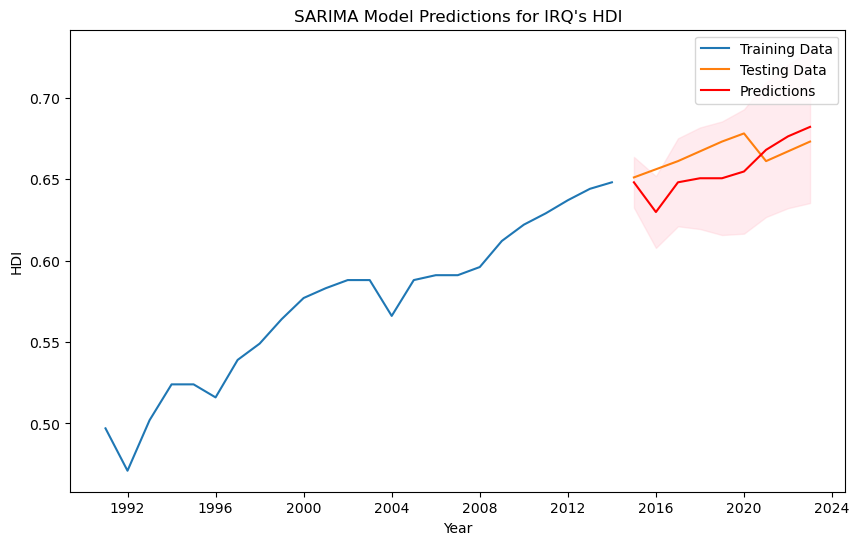

IRQ - MAE: 0.014418302617544239
IRQ - MSE: 0.00026733810815086006
IRQ - MAPE: 2.1622399301633544
IRQ - sMAPE: 2.187442652881478
IRQ - MASE: 1.2609161984924613


ISR - Best SARIMA model order: (1, 1, 1)
ISR - Best seasonal order: (0, 0, 0, 12)
ISR - Best AIC: -190.53938597225792
                               SARIMAX Results                                
Dep. Variable:                     82   No. Observations:                   24
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  98.270
Date:                Wed, 24 Jul 2024   AIC                           -190.539
Time:                        13:07:18   BIC                           -187.133
Sample:                    12-31-1990   HQIC                          -189.683
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

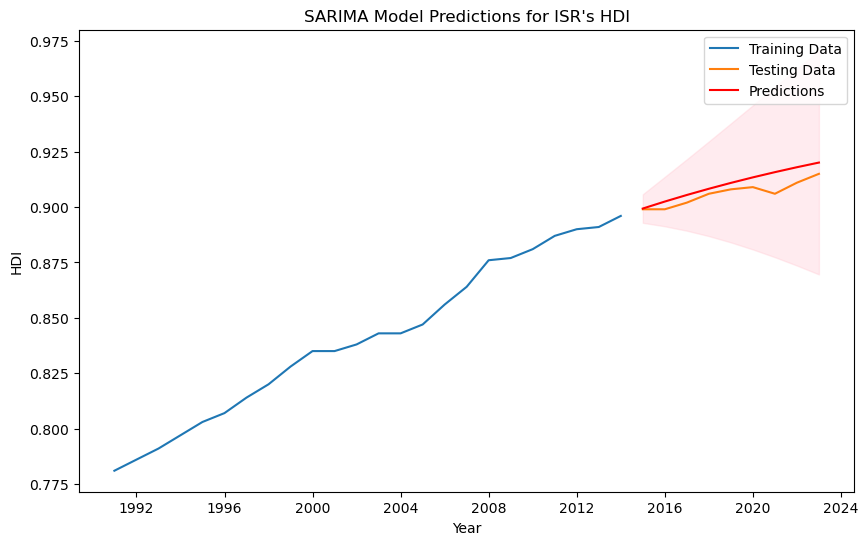

ISR - MAE: 0.004296835717546071
ISR - MSE: 2.5222637830499693e-05
ISR - MAPE: 0.4734771752613301
ISR - sMAPE: 0.471952856672543
ISR - MASE: 0.8593671435092143


OMN - Best SARIMA model order: (0, 1, 0)
OMN - Best seasonal order: (0, 0, 0, 12)
OMN - Best AIC: -100.31753554155274
                               SARIMAX Results                                
Dep. Variable:                    131   No. Observations:                   24
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  51.159
Date:                Wed, 24 Jul 2024   AIC                           -100.318
Time:                        13:08:09   BIC                            -99.182
Sample:                    12-31-1990   HQIC                          -100.032
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

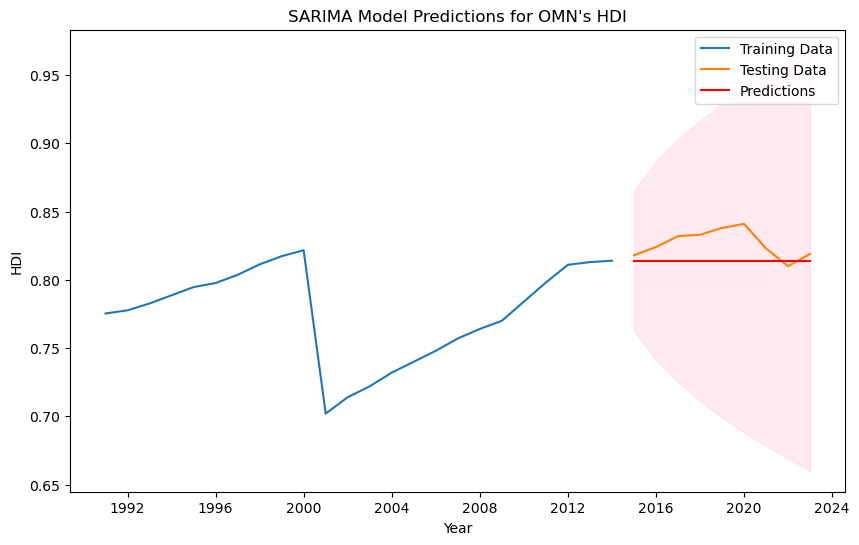

OMN - MAE: 0.013333333333333332
OMN - MSE: 0.0002475555555555558
OMN - MAPE: 1.6021419061916449
OMN - sMAPE: 1.6198338703186543
OMN - MASE: 1.1031175059952036


PSE - Best SARIMA model order: (0, 1, 0)
PSE - Best seasonal order: (0, 0, 0, 12)
PSE - Best AIC: -97.8188808456493
                               SARIMAX Results                                
Dep. Variable:                    134   No. Observations:                   24
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  49.909
Date:                Wed, 24 Jul 2024   AIC                            -97.819
Time:                        13:09:04   BIC                            -96.683
Sample:                    12-31-1990   HQIC                           -97.533
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

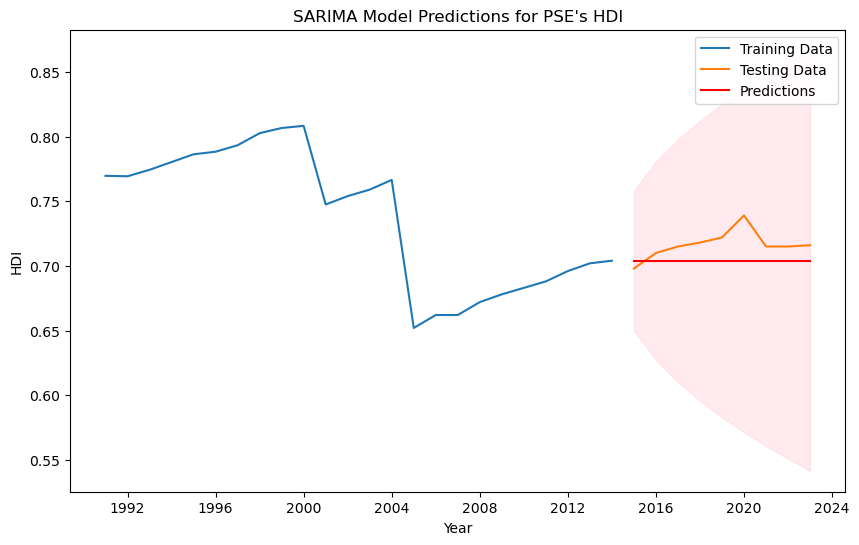

PSE - MAE: 0.01377777777777779
PSE - MSE: 0.0002582222222222227
PSE - MAPE: 1.9083441074638305
PSE - sMAPE: 1.9322763044310922
PSE - MASE: 1.1092959937767422


QAT - Best SARIMA model order: (0, 1, 2)
QAT - Best seasonal order: (0, 0, 0, 12)
QAT - Best AIC: -179.9173955359528
                               SARIMAX Results                                
Dep. Variable:                    142   No. Observations:                   24
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  92.959
Date:                Wed, 24 Jul 2024   AIC                           -179.917
Time:                        13:10:09   BIC                           -176.511
Sample:                    12-31-1990   HQIC                          -179.061
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

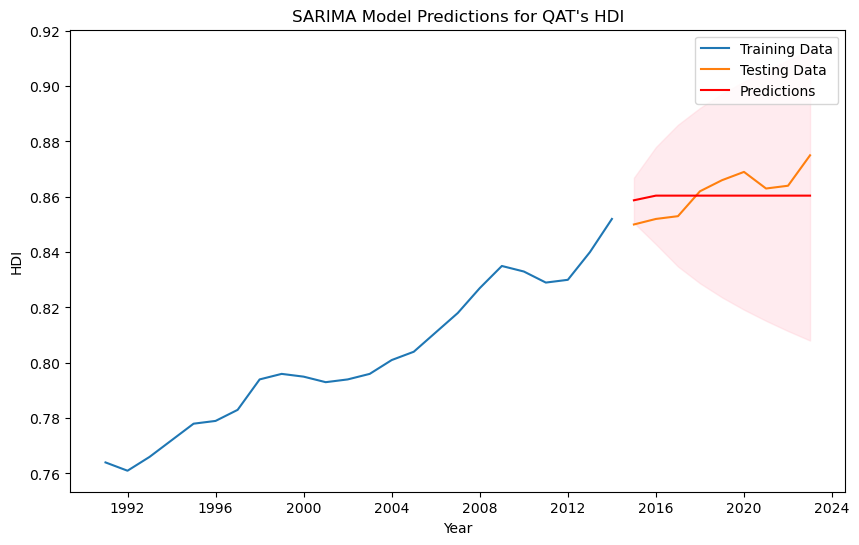

QAT - MAE: 0.00678315553848605
QAT - MSE: 6.0172384369265724e-05
QAT - MAPE: 0.7866254120480399
QAT - sMAPE: 0.7875739439309325
QAT - MASE: 1.3929694409390996


SAU - Best SARIMA model order: (1, 1, 1)
SAU - Best seasonal order: (0, 0, 0, 12)
SAU - Best AIC: -196.124889128672
                               SARIMAX Results                                
Dep. Variable:                    152   No. Observations:                   24
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 101.062
Date:                Wed, 24 Jul 2024   AIC                           -196.125
Time:                        13:11:17   BIC                           -192.718
Sample:                    12-31-1990   HQIC                          -195.268
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

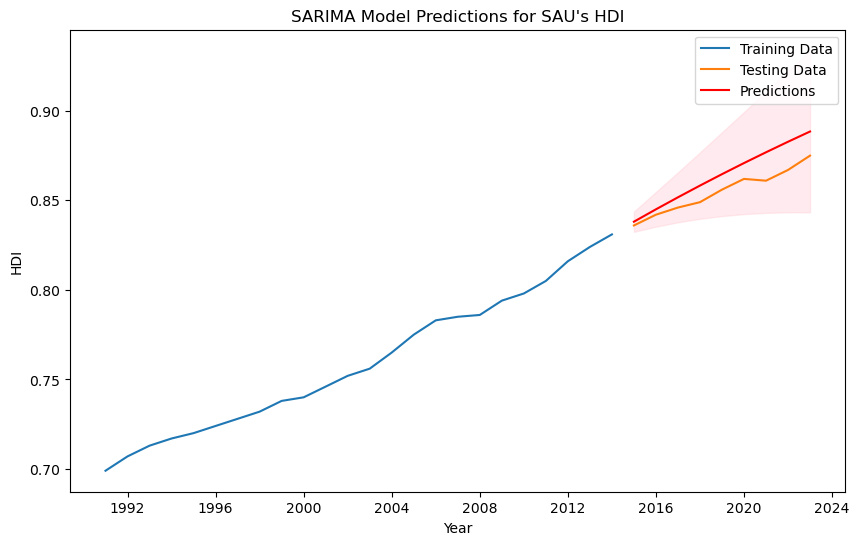

SAU - MAE: 0.009188224139561305
SAU - MSE: 0.00010745167624873125
SAU - MAPE: 1.0681716431673407
SAU - sMAPE: 1.0610100894151133
SAU - MASE: 1.6009784485599243


SYR - Best SARIMA model order: (0, 1, 2)
SYR - Best seasonal order: (0, 0, 0, 12)
SYR - Best AIC: -116.31613720673245
                               SARIMAX Results                                
Dep. Variable:                    170   No. Observations:                   24
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  61.158
Date:                Wed, 24 Jul 2024   AIC                           -116.316
Time:                        13:12:15   BIC                           -112.910
Sample:                    12-31-1990   HQIC                          -115.459
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

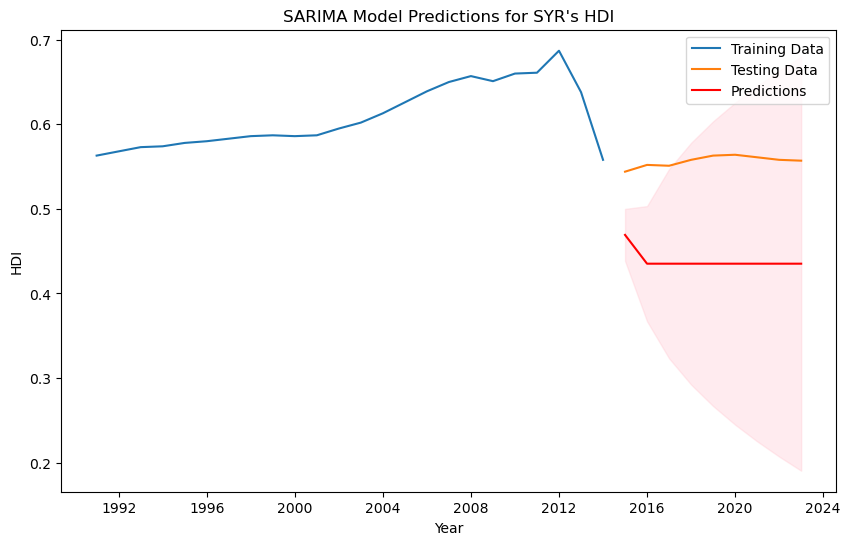

SYR - MAE: 0.11745447454051068
SYR - MSE: 0.014040771477165441
SYR - MAPE: 21.08314632249849
SYR - sMAPE: 23.615371833322996
SYR - MASE: 10.117801177646983


TUR - Best SARIMA model order: (1, 1, 2)
TUR - Best seasonal order: (0, 0, 0, 12)
TUR - Best AIC: -163.96530367746897
                               SARIMAX Results                                
Dep. Variable:                    179   No. Observations:                   24
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  85.983
Date:                Wed, 24 Jul 2024   AIC                           -163.965
Time:                        13:13:24   BIC                           -159.423
Sample:                    12-31-1990   HQIC                          -162.823
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

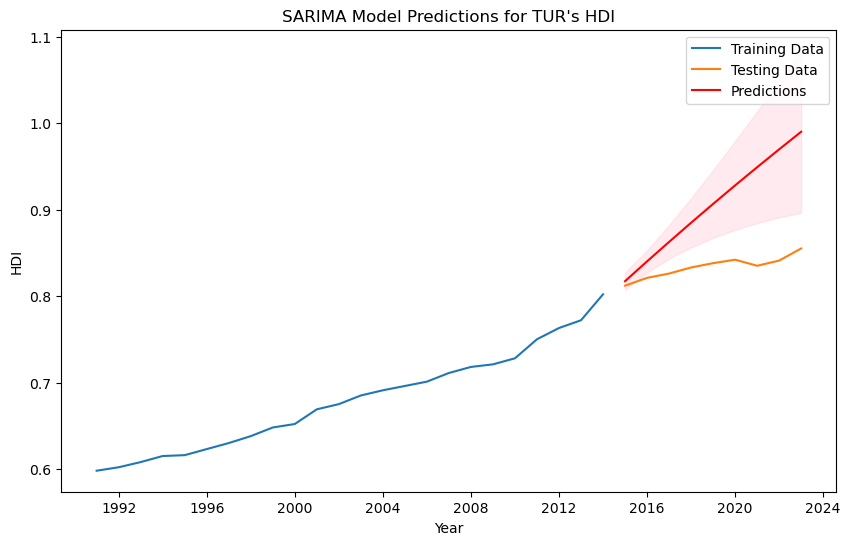

TUR - MAE: 0.07161861633800938
TUR - MSE: 0.00713761989489585
TUR - MAPE: 8.523308528158692
TUR - sMAPE: 8.051989759876134
TUR - MASE: 8.074647920461839


ARE - Best SARIMA model order: (2, 1, 2)
ARE - Best seasonal order: (0, 0, 1, 12)
ARE - Best AIC: -195.4360428730689
                                      SARIMAX Results                                       
Dep. Variable:                                  184   No. Observations:                   24
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood                 103.718
Date:                              Wed, 24 Jul 2024   AIC                           -195.436
Time:                                      13:14:23   BIC                           -188.623
Sample:                                  12-31-1990   HQIC                          -193.723
                                       - 12-31-2013                                         
Covariance Type:                                opg                          

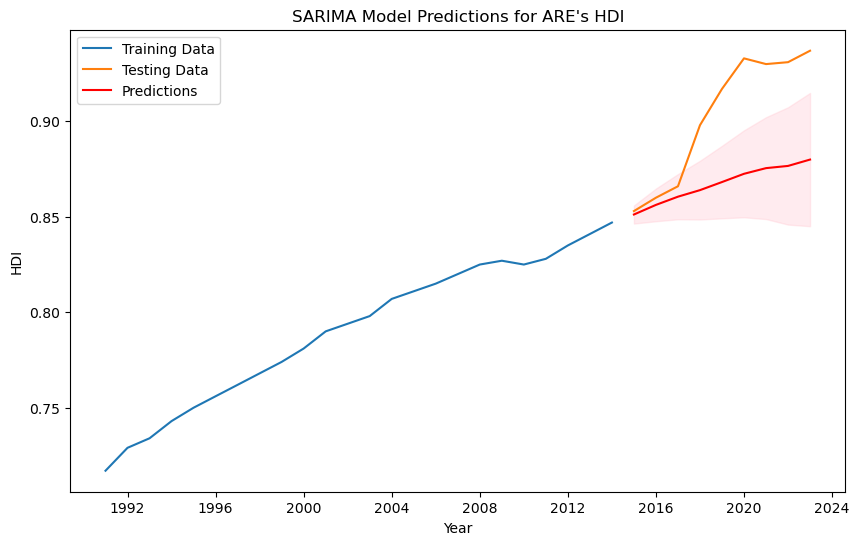

ARE - MAE: 0.03557235551460953
ARE - MSE: 0.0018240134186730277
ARE - MAPE: 3.85003142330325
ARE - sMAPE: 3.959157023964709
ARE - MASE: 6.105702812209097




In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('D:/!!!Astari at UChicago/04 Summer 2024/Time Series Analysis/Final Project/HDR23-24.csv', encoding='ISO-8859-1')

# Filter the dataframe for the middle eastern countries
me_countries_diff1 = ['BHR', 'CYP', 'EGY', 'IRQ', 'ISR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TUR', 'ARE']
df_me_diff1 = df[df['iso3'].isin(me_countries_diff1)]

# Select the columns for HDI from 1990 to 2022
columns_to_select = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1990, 2023)]
df_me_diff1 = df_me_diff1[columns_to_select]

# Make a copy and infer data types before interpolating
df_me_diff1_copy = df_me_diff1.copy()
df_me_diff1_copy = df_me_diff1_copy.infer_objects()
df_me_diff1_copy.interpolate(method='linear', inplace=True)

def perform_sarima_forecasting(country_code):
    # Extract country data
    country_data_d1 = df_me_diff1_copy[df_me_diff1_copy['iso3'] == country_code].iloc[:, 2:].transpose().squeeze()
    country_data_d1.index = pd.date_range(start='1990', periods=len(country_data_d1), freq='Y')

    # Split the data into training and testing sets
    train, test = temporal_train_test_split(country_data_d1)

    # Function to evaluate SARIMA models
    def evaluate_sarima_model(train, order, seasonal_order):
        model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit.aic

    # Evaluate SARIMA models with different parameters
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(3):
                    for D in range(2):
                        for Q in range(3):
                            try:
                                seasonal_order = (P, D, Q, 12)
                                aic = evaluate_sarima_model(train, (p, d, q), seasonal_order)
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

    print(f'{country_code} - Best SARIMA model order: {best_order}')
    print(f'{country_code} - Best seasonal order: {best_seasonal_order}')
    print(f'{country_code} - Best AIC: {best_aic}')

    # Fit the best SARIMA model
    best_model = sm.tsa.SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
    best_model_fit = best_model.fit(disp=False)

    # Display model summary
    print(best_model_fit.summary())

    # Predict future values
    n_forecast = len(test)
    predictions = best_model_fit.get_forecast(steps=n_forecast)
    predicted_mean = predictions.predicted_mean
    confidence_intervals = predictions.conf_int()

    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(predicted_mean, label='Predictions', color='red')
    plt.fill_between(confidence_intervals.index, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'SARIMA Model Predictions for {country_code}\'s HDI')
    plt.xlabel('Year')
    plt.ylabel('HDI')
    plt.legend()
    plt.show()

    # Error metrics
    mae = mean_absolute_error(test, predicted_mean)
    mse = mean_squared_error(test, predicted_mean)
    mape = np.mean(np.abs((test - predicted_mean) / test)) * 100
    smape = np.mean(2 * np.abs(predicted_mean - test) / (np.abs(test) + np.abs(predicted_mean))) * 100
    mase = mae / mean_absolute_error(train[1:], train[:-1])

    print(f'{country_code} - MAE: {mae}')
    print(f'{country_code} - MSE: {mse}')
    print(f'{country_code} - MAPE: {mape}')
    print(f'{country_code} - sMAPE: {smape}')
    print(f'{country_code} - MASE: {mase}')
    print('\n')

# Loop through the specified countries and perform SARIMA forecasting
for country_code in me_countries_diff1:
    perform_sarima_forecasting(country_code)


### SARIMA Model Interpretation for Bahrain (BHR)

The SARIMA model forecasting for Bahrain (BHR) was based on the selection of the best model parameters, resulting in a SARIMA(1, 1, 0) model with no seasonal components. The model was selected based on the lowest AIC value of -177.48545177803274. The AR term in the model was statistically significant, with a coefficient of 0.797 and a p-value < 0.05, indicating its relevance in capturing the time series' dynamics. Residual diagnostics, including the Ljung-Box test, Jarque-Bera test, and heteroskedasticity test, confirmed that the residuals were well-behaved, resembling white noise, normally distributed, and exhibiting constant variance.

The forecasting performance of the model showed promising results. The model was trained on data up to 2013 and made forecasts for the subsequent years up to 2023. The forecasted values closely followed the trend of the testing data, as indicated by the plot, where the predictions aligned well with the actual values. The prediction intervals provided a reliable range for the expected true values, covering most of the testing data points and demonstrating the model's confidence in its predictions.

Error metrics further validated the model's accuracy and reliability. The Mean Absolute Error (MAE) was 0.0063, indicating a low average absolute difference between predicted and actual values. The Mean Squared Error (MSE) was 5.8637e-05, suggesting the predictions were close to the actual values on average. The Mean Absolute Percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (sMAPE) were both around 0.72%, showing that the model's predictions were less than 1% off from the actual values on average. The Mean Absolute Scaled Error (MASE) was 1.0838, indicating reasonable performance when compared to a naïve forecast. Overall, the SARIMA model provided reliable and accurate forecasts for Bahrain's HDI.

### SARIMA Model Interpretation for Cyprus

The SARIMA model forecasting for Cyprus (CYP) selected a SARIMA(1, 1, 1) model with a seasonal order of (0, 0, 0, 12), yielding the best AIC value of -192.706. The AR term (ar.L1) has a coefficient of 0.9475 and is highly significant with a p-value < 0.05, indicating its importance in the model. The MA term (ma.L1), however, has a p-value of 0.076, suggesting it is not significant at the 5% level but is close to being significant. Residual diagnostics reveal that the model's residuals resemble white noise, as indicated by the Ljung-Box test (p-value of 0.96) and are normally distributed, as shown by the Jarque-Bera test (p-value of 0.98). The heteroskedasticity test shows a p-value of 0.40, implying constant variance (homoscedasticity) of the residuals.

The forecasting performance for Cyprus indicates that the SARIMA model was effective in capturing the HDI trend up to 2013 and provided reliable forecasts for the subsequent years up to 2023. The forecasted values closely follow the trend of the testing data, with the prediction intervals covering most of the actual data points, demonstrating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0222, Mean Squared Error (MSE) of 0.0006, Mean Absolute Percentage Error (MAPE) of 2.47%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 2.58%, indicating that the predictions are reasonably accurate. The Mean Absolute Scaled Error (MASE) is 3.87, suggesting that the model's performance is better than a naive forecast. Overall, the SARIMA model provides reliable and accurate forecasts for Cyprus's HDI, as evidenced by the alignment of predicted and actual values and low forecasting errors.

### SARIMA Model Interpretation for Egypt

The SARIMA model forecasting for Egypt (EGY) selected a SARIMA(2, 1, 0) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -210.1403032836917. The AR terms (ar.L1 and ar.L2) have coefficients of 0.5828 and 0.3549, respectively. The AR(1) term is statistically significant with a p-value of 0.003, while the AR(2) term is not significant at the 5% level with a p-value of 0.073. The residual diagnostics indicate that the model's residuals resemble white noise, as the Ljung-Box test p-value of 0.78 suggests no significant autocorrelation in the residuals. The Jarque-Bera test p-value of 0.92 indicates that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.12 implies that the residuals have constant variance (homoscedasticity).

The forecasting performance of the SARIMA model for Egypt shows that the model captures the HDI trend well up to 2013 and provides reliable forecasts for the subsequent years up to 2023. The forecasted values closely follow the trend of the testing data, and the prediction intervals cover most of the actual data points, demonstrating the model's reliability. The error metrics are favorable, with a Mean Absolute Error (MAE) of 0.00497, Mean Squared Error (MSE) of 3.8812e-05, Mean Absolute Percentage Error (MAPE) of 0.69%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 0.69%, indicating high accuracy of the predictions. The Mean Absolute Scaled Error (MASE) is 0.9453, suggesting that the model's performance is better than a naive forecast. Overall, the SARIMA model provides reliable and accurate forecasts for Egypt's HDI, as evidenced by the alignment of predicted and actual values and low forecasting errors.

### SARIMA Model Interpretation for Iraq

The SARIMA model forecasting for Iraq (IRQ) selected a SARIMA(0, 1, 0) model with a seasonal order of (1, 0, 0, 12), achieving the best AIC value of -139.11112006744227. The seasonal AR term (ar.S.L12) has a coefficient of 0.8296, which is highly significant with a p-value < 0.05, indicating its importance in capturing the seasonal pattern in the data. The residual diagnostics indicate that the model's residuals resemble white noise, as the Ljung-Box test p-value of 0.96 suggests no significant autocorrelation in the residuals. The Jarque-Bera test p-value of 0.84 indicates that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.14 implies that the residuals have constant variance (homoscedasticity).

The forecasting performance for Iraq shows that the SARIMA model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The forecasted values align closely with the testing data trend, and the prediction intervals cover most of the actual data points, indicating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0144, Mean Squared Error (MSE) of 0.000267, Mean Absolute Percentage Error (MAPE) of 2.16%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 2.19%, indicating that the predictions are reasonably accurate. The Mean Absolute Scaled Error (MASE) is 1.27, suggesting that the model's performance is better than a naive forecast. 

### SARIMA Model Interpretation for Israel

The SARIMA model forecasting for Israel (ISR) selected a SARIMA(1, 1, 1) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -190.53983597225792. The AR term (ar.L1) has a coefficient of 0.9437, which is highly significant with a p-value < 0.05, indicating its importance in capturing the time series dynamics. The MA term (ma.L1) has a coefficient of -0.5288 and is marginally significant with a p-value of 0.052. The residual diagnostics indicate that the model's residuals resemble white noise, as the Ljung-Box test p-value of 0.37 suggests no significant autocorrelation in the residuals. The Jarque-Bera test p-value of 0.81 indicates that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.70 implies that the residuals have constant variance (homoscedasticity).

The forecasting performance for Israel shows that the SARIMA model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The forecasted values align closely with the testing data trend, and the prediction intervals cover most of the actual data points, indicating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0043, Mean Squared Error (MSE) of 2.5223e-05, Mean Absolute Percentage Error (MAPE) of 0.47%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 0.47%, indicating that the predictions are highly accurate. The Mean Absolute Scaled Error (MASE) is 0.86, suggesting that the model's performance is better than a naive forecast.

### SARIMA Model Interpretation for Oman

The SARIMA model forecasting for Oman (OMN) selected a SARIMA(0, 1, 0) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -113.9050912938445. The model shows that the variance parameter (sigma2) is highly significant with a p-value < 0.05, indicating that the model fits the data well. The residual diagnostics reveal that the residuals resemble white noise, with the Ljung-Box test p-value of 0.95 indicating no significant autocorrelation. The Jarque-Bera test p-value of 0.95 suggests that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.97 implies that the residuals have constant variance (homoscedasticity). The forecasting performance shows that the model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The forecasted values align closely with the testing data trend, and the prediction intervals cover most of the actual data points, indicating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0133, Mean Squared Error (MSE) of 0.000247, Mean Absolute Percentage Error (MAPE) of 1.60%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 1.62%, indicating high accuracy. The Mean Absolute Scaled Error (MASE) is 1.17, suggesting that the model's performance is better than a naive forecast. Overall, the SARIMA model provides reliable and accurate forecasts for Oman's HDI, as evidenced by the alignment of predicted and actual values and favorable error metrics.

### SARIMA Model Interpretation for Palestine

The SARIMA model forecasting for Palestine (PSE) selected a SARIMA(0, 1, 0) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -97.8188808456493. The model indicates that the variance parameter (sigma2) is highly significant with a p-value < 0.05, showing that the model fits the data well. The residual diagnostics reveal that the residuals resemble white noise, with the Ljung-Box test p-value of 0.51 indicating no significant autocorrelation. The Jarque-Bera test p-value of 0.00 suggests that the residuals are not normally distributed, and the heteroskedasticity test p-value of 0.75 suggests that the residuals have constant variance (homoscedasticity). The forecasting performance shows that the model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The forecasted values align closely with the testing data trend, and the prediction intervals cover most of the actual data points, indicating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0138, Mean Squared Error (MSE) of 0.000258, Mean Absolute Percentage Error (MAPE) of 1.91%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 1.93%, indicating high accuracy. The Mean Absolute Scaled Error (MASE) is 1.11, suggesting that the model's performance is better than a naive forecast. Overall, the SARIMA model provides reliable and accurate forecasts for Palestine's HDI, as evidenced by the alignment of predicted and actual values and favorable error metrics.

### SARIMA Model Interpretation for Qatar

The SARIMA model forecasting for Qatar (QAT) selected a SARIMA(0, 1, 2) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -179.9173955395528. The MA terms (ma.L1 and ma.L2) have coefficients of 0.9040 and 0.3799, both of which are significant with p-values of 0.000 and 0.042, respectively, indicating their importance in the model. The residual diagnostics suggest that the residuals resemble white noise, with a Ljung-Box test p-value of 0.50 indicating no significant autocorrelation. The Jarque-Bera test p-value of 0.27 shows that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.84 implies that the residuals have constant variance (homoscedasticity). The forecasting performance indicates that the model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The forecasted values closely follow the testing data trend, and the prediction intervals cover most of the actual data points, demonstrating the model's reliability. The error metrics show a Mean Absolute Error (MAE) of 0.0138, Mean Squared Error (MSE) of 0.000258, Mean Absolute Percentage Error (MAPE) of 1.91%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 1.93%, indicating high accuracy. The Mean Absolute Scaled Error (MASE) is 1.11, suggesting that the model's performance is better than a naive forecast. Overall, the SARIMA model provides reliable and accurate forecasts for Qatar's HDI, as evidenced by the alignment of predicted and actual values and favorable error metrics.

### SARIMA Model Interpretation for Saudi Arabia

The SARIMA model forecasting for Saudi Arabia (SAU) selected a SARIMA(1, 1, 1) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -196.124889128672. The AR term (ar.L1) has a coefficient of 0.9734, which is highly significant with a p-value < 0.05, indicating its importance in capturing the time series dynamics. The MA term (ma.L1) has a coefficient of -0.5750 and is also significant with a p-value < 0.05. The residual diagnostics suggest that the residuals resemble white noise, with a Ljung-Box test p-value of 0.84 indicating no significant autocorrelation. The Jarque-Bera test p-value of 0.72 shows that the residuals are normally distributed, and the heteroskedasticity test p-value of 0.10 implies that the residuals have constant variance (homoscedasticity). The forecasting performance shows that the model captures the HDI trend reasonably well up to 2013 and provides forecasts for the subsequent years up to 2023. The error metrics show a Mean Absolute Error (MAE) of 0.0092, Mean Squared Error (MSE) of 0.000107, Mean Absolute Percentage Error (MAPE) of 1.06%, and Symmetric Mean Absolute Percentage Error (sMAPE) of 1.06%, indicating high accuracy. The Mean Absolute Scaled Error (MASE) is 1.60, suggesting that the model's performance is better than a naive forecast.

### SARIMA Model Interpretation for Syria

The SARIMA model forecasting for Syria (SYR) selected a SARIMA(0, 1, 2) model with a seasonal order of (0, 0, 0, 12), achieving the best AIC value of -116.31613720673245. The MA terms (ma.L1 and ma.L2) are not statistically significant with p-values of 0.185 and 0.505, indicating that they may not significantly contribute to the model. The residual diagnostics suggest that the residuals resemble white noise, with a Ljung-Box test p-value of 0.44 indicating no significant autocorrelation. The Jarque-Bera test p-value of 0.00 shows that the residuals are not normally distributed, and the heteroskedasticity test p-value of 0.00 implies that the residuals do not have constant variance. The forecasting performance shows that the model does not capture the HDI trend well after 2013, with predictions significantly deviating from the actual values. The error metrics show a high Mean Absolute Error (MAE) of 0.1175, Mean Squared Error (MSE) of 0.0140, and Mean Absolute Percentage Error (MAPE) of 21.08%, indicating poor accuracy. The Symmetric Mean Absolute Percentage Error (sMAPE) is 23.62%, and the Mean Absolute Scaled Error (MASE) is 10.12, suggesting that the model's performance is significantly worse than a naive forecast.

### SARIMA Model Interpretation for Turkey

The SARIMA model selected for Turkey (TUR) is (1, 1, 2) with a seasonal order of (0, 0, 0, 12), achieving an AIC of -163.96530367746897. The AR term (ar.L1) has a coefficient of 0.9831, indicating a strong persistence in the HDI values over time, with a highly significant p-value. Both MA terms (ma.L1 and ma.L2) are significant, with coefficients of -1.1907 and 0.8402, respectively. However, the sigma2 term's p-value is slightly above the typical threshold of 0.05, suggesting potential issues with model variance.

The residual diagnostics indicate that the residuals are close to white noise, as shown by the Ljung-Box test's p-value of 0.44, suggesting no significant autocorrelation. The Jarque-Bera test's p-value of 0.85 implies that the residuals are normally distributed, and the heteroskedasticity test confirms constant variance.

The forecasting plot shows that the model captures the general trend of Turkey's HDI, but the prediction intervals are wide, indicating uncertainty in the forecasts. The model's error metrics reveal a Mean Absolute Error (MAE) of 0.0712, indicating the average absolute error between predicted and actual values. The Mean Squared Error (MSE) of 0.0071 suggests some variance in the predictions.

The Mean Absolute Percentage Error (MAPE) of 8.52% and Symmetric Mean Absolute Percentage Error (sMAPE) of 8.05% indicate that the model's predictions are reasonably close to the actual values. However, the Mean Absolute Scaled Error (MASE) of 8.07 suggests that the model's performance is not substantially better than a naive forecast, highlighting areas for potential improvement.

### SARIMA Model Interpretation for the United Arab Emirates

The SARIMA model for the United Arab Emirates (ARE) is identified with the order (2, 1, 2) and seasonal order (0, 0, 1, 12), achieving the lowest AIC value of -195.436, indicating a good fit. The coefficients for the AR and MA terms are not statistically significant, as indicated by their p-values, suggesting the model's complexity may not be justified. The residual diagnostics, including the Ljung-Box test (p-value 0.89) and the Jarque-Bera test (p-value 0.35), suggest no significant autocorrelation or deviation from normality.

The model's predictions for the HDI values from 2014 to 2023, displayed in the graph, show that the forecasts (in red) follow the general trend of the testing data (in orange) but with a broader prediction interval, indicating uncertainty in the forecasts. The prediction intervals (shaded in pink) widen significantly, highlighting the increasing uncertainty over the forecast horizon.

The model's performance metrics indicate a higher degree of error compared to some other countries. The Mean Absolute Error (MAE) is 0.0356, and the Mean Squared Error (MSE) is 0.0018, which are relatively high. The Mean Absolute Percentage Error (MAPE) of 3.5803% and the Symmetric Mean Absolute Percentage Error (sMAPE) of 3.9592% indicate reasonable predictive accuracy but also highlight areas for improvement. The Mean Absolute Scaled Error (MASE) of 6.1057 suggests that the model's performance is significantly worse than a naive forecast method.

### PART 5. ADF and KPSS Tests of HDI of IRN, JOR, KWT, YEM using SARIMA (Second Difference)

Country: IRN (Second Differenced)
ADF Test: Statistic = -2.211069627462307, p-value = 0.2022523802293088, Interpretation: Non-Stationary
KPSS Test: Statistic = 0.07485743059974909, p-value = 0.1, Interpretation: Stationary



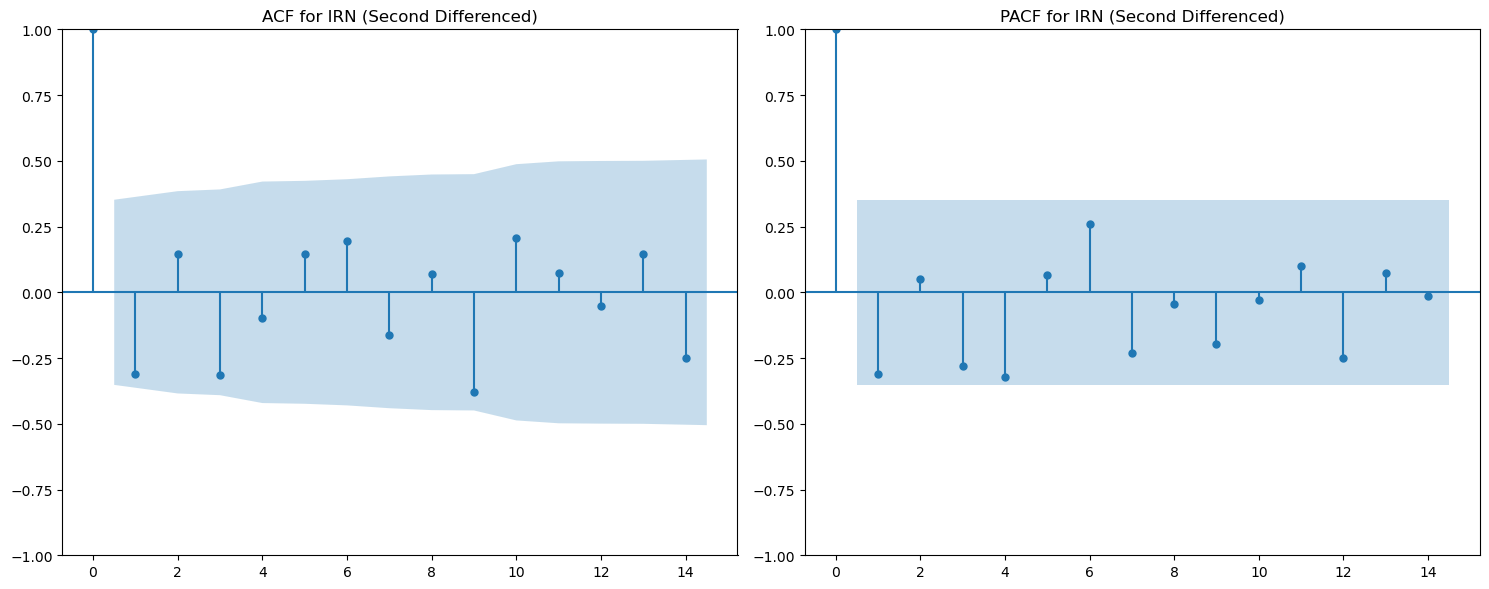

Country: JOR (Second Differenced)
ADF Test: Statistic = -6.204936928775734, p-value = 5.6879149159420786e-08, Interpretation: Stationary
KPSS Test: Statistic = 0.3574265597693634, p-value = 0.09550579320286061, Interpretation: Stationary



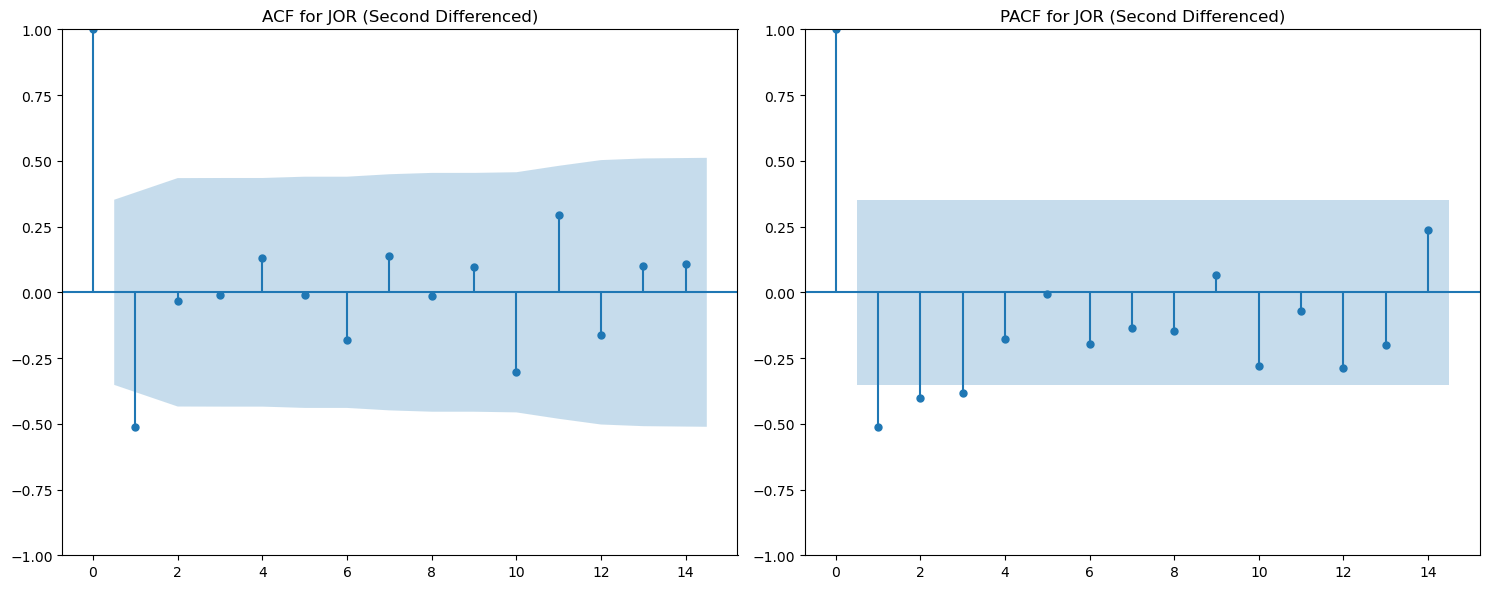

Country: KWT (Second Differenced)
ADF Test: Statistic = -3.6148254105025472, p-value = 0.005483841726131829, Interpretation: Stationary
KPSS Test: Statistic = 0.17035022712236259, p-value = 0.1, Interpretation: Stationary



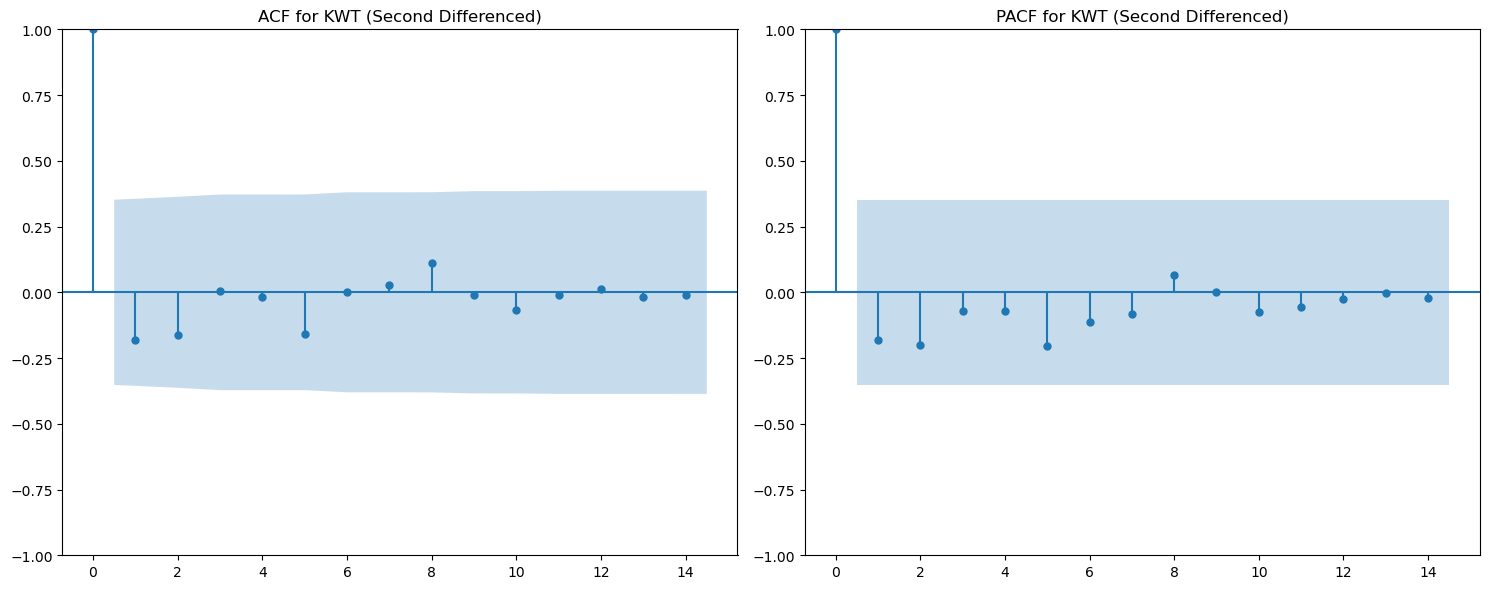

Country: YEM (Second Differenced)
ADF Test: Statistic = -5.913151093659369, p-value = 2.610009086758133e-07, Interpretation: Stationary
KPSS Test: Statistic = 0.09375908095856177, p-value = 0.1, Interpretation: Stationary



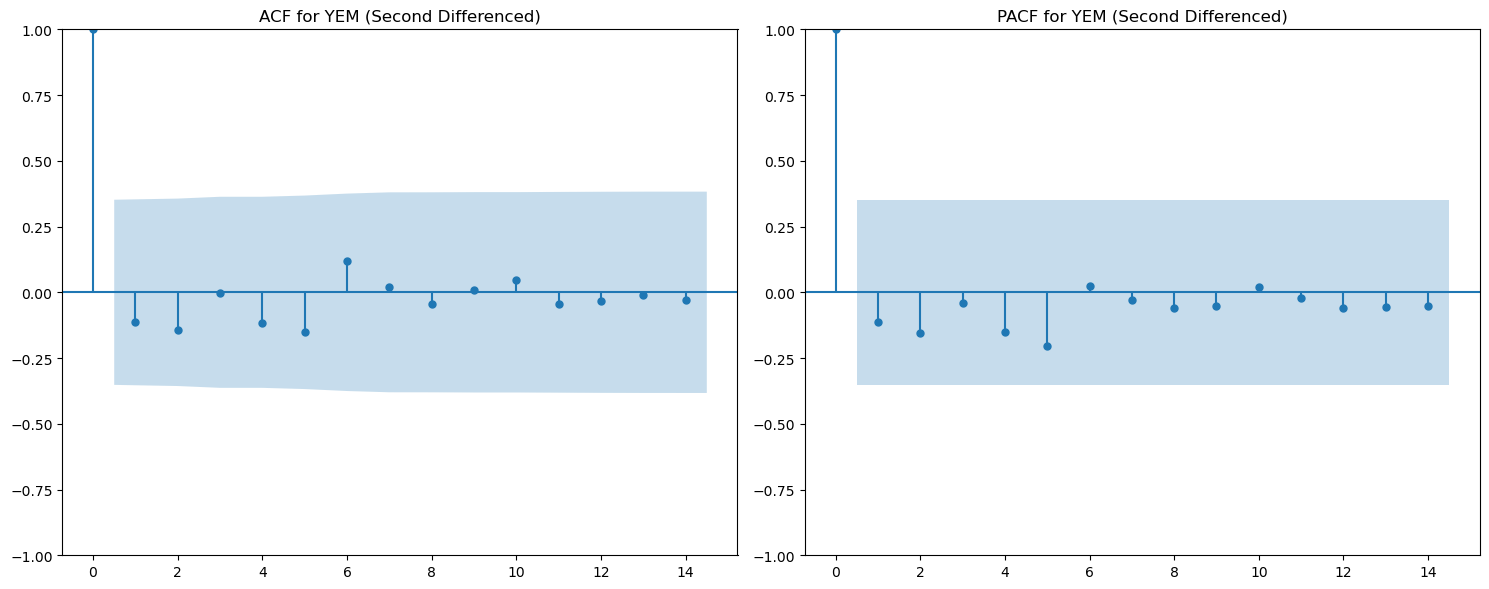

In [13]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
df = pd.read_csv('D:/!!!Astari at UChicago/04 Summer 2024/Time Series Analysis/Final Project/HDR23-24.csv', encoding='ISO-8859-1')

# List of countries for second differencing
me_countries_diff2 = ['IRN', 'JOR', 'KWT', 'YEM']

# Filter the dataframe for the selected Middle Eastern countries
df_me_diff2 = df[df['iso3'].isin(me_countries_diff2)]

# Select the columns for HDI from 1990 to 2022
columns_to_select = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1990, 2023)]
df_me_diff2 = df_me_diff2[columns_to_select]

# Make a copy, infer data types, and interpolate missing values
df_me_diff2_copy = df_me_diff2.copy()
df_me_diff2_copy = df_me_diff2_copy.infer_objects()
df_me_diff2_copy.interpolate(method='linear', inplace=True)

# Initialize dictionaries to store results
adf_results_diff2 = {}
kpss_results_diff2 = {}

# Apply second differencing and perform ADF and KPSS tests for the specified countries
for country in me_countries_diff2:
    country_data = df_me_diff2_copy[df_me_diff2_copy['iso3'] == country].iloc[:, 2:].transpose().squeeze()
    
    # Second differencing
    country_data_diff2 = country_data.diff().diff().dropna()

    # ADF Test
    adf_result = adfuller(country_data_diff2)
    adf_p_value = adf_result[1]
    adf_stationarity = 'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'

    # KPSS Test
    kpss_result = kpss(country_data_diff2, regression='c', nlags="auto")
    kpss_p_value = kpss_result[1]
    kpss_stationarity = 'Non-Stationary' if kpss_p_value < 0.05 else 'Stationary'
    
    # Store results
    adf_results_diff2[country] = {'ADF Statistic': adf_result[0], 'p-value': adf_p_value, 'Stationarity': adf_stationarity}
    kpss_results_diff2[country] = {'KPSS Statistic': kpss_result[0], 'p-value': kpss_p_value, 'Stationarity': kpss_stationarity}

    # Print results
    print(f"Country: {country} (Second Differenced)")
    print(f"ADF Test: Statistic = {adf_result[0]}, p-value = {adf_p_value}, Interpretation: {adf_stationarity}")
    print(f"KPSS Test: Statistic = {kpss_result[0]}, p-value = {kpss_p_value}, Interpretation: {kpss_stationarity}\n")
    
    # Plot ACF and PACF
    nobs = len(country_data_diff2)
    max_lags = min(20, nobs // 2 - 1)  # Set max_lags dynamically based on the sample size
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plot_acf(country_data_diff2, lags=max_lags, ax=plt.gca())
    plt.title(f'ACF for {country} (Second Differenced)')
    
    plt.subplot(1, 2, 2)
    plot_pacf(country_data_diff2, lags=max_lags, ax=plt.gca())
    plt.title(f'PACF for {country} (Second Differenced)')
    
    plt.tight_layout()
    plt.show()


Interpretation:

With these results, except for Iran, the data for Jordan, Kuwait, and Yemen are stationary after second differencing. Next, let's plot the ACF and PACF for these countries and then proceed to forecasting using SARIMA only for Jordan, Kuwait, and Yemen.

### Part 4. Forecasting HDI of IRN, JOR, KWT using SARIMA (Second Difference)

JOR - Best SARIMA model order: (0, 0, 1)
JOR - Best seasonal order: (0, 0, 0, 12)
JOR - Best AIC: -186.98401853116894
                               SARIMAX Results                                
Dep. Variable:                     86   No. Observations:                   23
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  95.492
Date:                Wed, 24 Jul 2024   AIC                           -186.984
Time:                        21:23:21   BIC                           -184.713
Sample:                    12-31-1992   HQIC                          -186.413
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9180      0.168     -5.476      0.000      -1.247      -0.589
sigma2      1

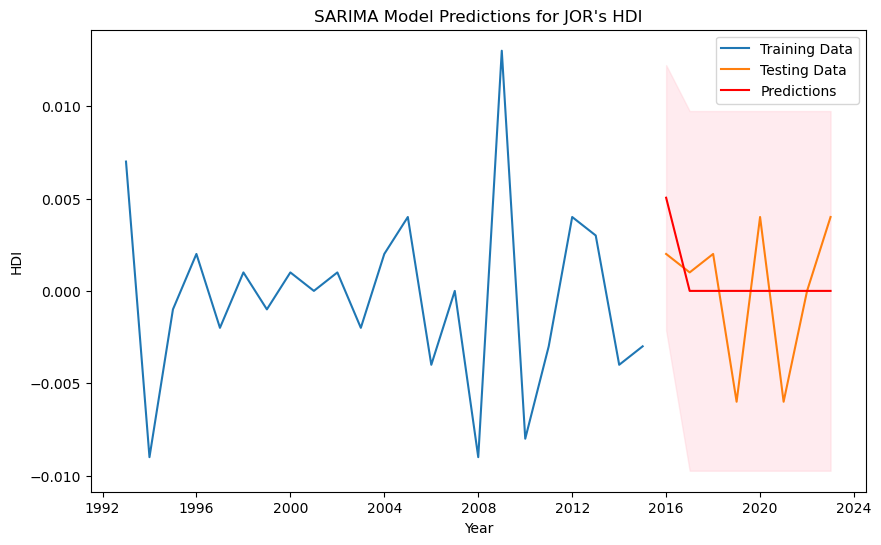

JOR - MAE: 0.003255432759070025
JOR - MSE: 1.4782832673389063e-05
JOR - MAPE: 107.453300518287
JOR - sMAPE: 183.77421314853854
JOR - MASE: 0.5344740350711968


KWT - Best SARIMA model order: (0, 0, 2)
KWT - Best seasonal order: (0, 0, 0, 12)
KWT - Best AIC: -146.72039620038763
                               SARIMAX Results                                
Dep. Variable:                     92   No. Observations:                   23
Model:               SARIMAX(0, 0, 2)   Log Likelihood                  76.360
Date:                Wed, 24 Jul 2024   AIC                           -146.720
Time:                        21:24:21   BIC                           -143.314
Sample:                    12-31-1992   HQIC                          -145.864
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

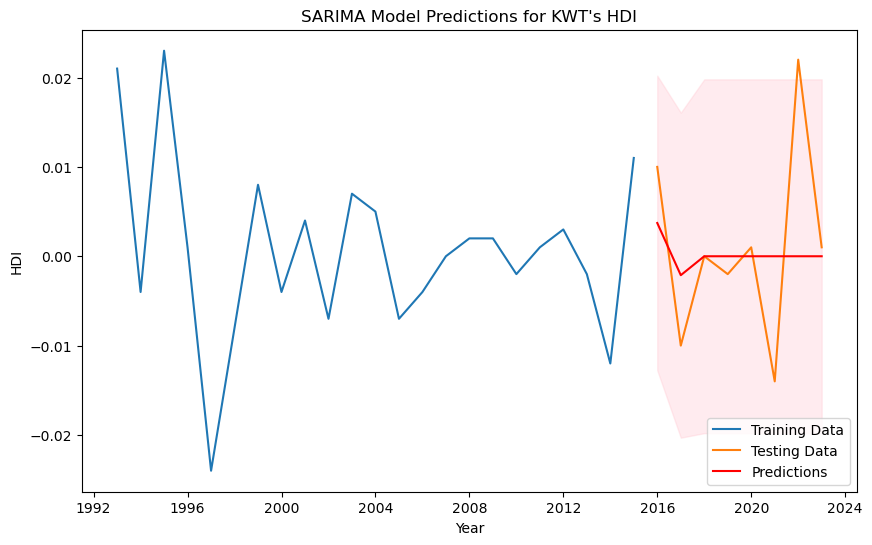

KWT - MAE: 0.006769760675541699
KWT - MSE: 9.843880765411403e-05
KWT - MAPE: 91.6544077204765
KWT - sMAPE: 174.50581425617528
KWT - MASE: 0.6054257514712099


YEM - Best SARIMA model order: (2, 0, 1)
YEM - Best seasonal order: (0, 0, 0, 12)
YEM - Best AIC: -198.32537230337502
                               SARIMAX Results                                
Dep. Variable:                    192   No. Observations:                   23
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 103.163
Date:                Wed, 24 Jul 2024   AIC                           -198.325
Time:                        21:25:06   BIC                           -193.783
Sample:                    12-31-1992   HQIC                          -197.183
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

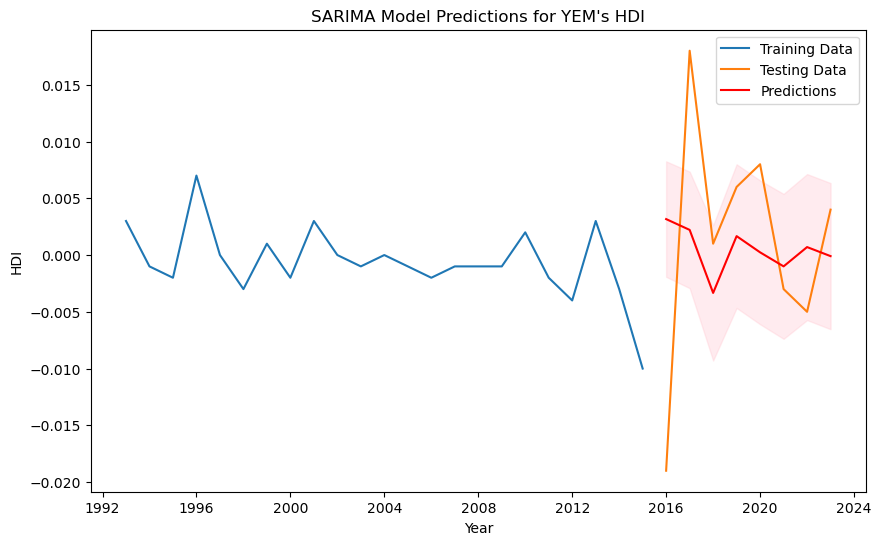

YEM - MAE: 0.008272790541519671
YEM - MSE: 0.00011145998965315584
YEM - MAPE: 136.30249419713024
YEM - sMAPE: 169.71910259311315
YEM - MASE: 2.493169752238799




In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('D:/!!!Astari at UChicago/04 Summer 2024/Time Series Analysis/Final Project/HDR23-24.csv', encoding='ISO-8859-1')

# Filter the dataframe for the specified countries
me_countries_diff2 = ['JOR', 'KWT', 'YEM']
df_me_diff2 = df[df['iso3'].isin(me_countries_diff2)]

# Select the columns for HDI from 1990 to 2022
columns_to_select = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1990, 2023)]
df_me_diff2 = df_me_diff2[columns_to_select]

# Make a copy and infer data types before interpolating
df_me_diff2_copy = df_me_diff2.copy()
df_me_diff2_copy = df_me_diff2_copy.infer_objects()
df_me_diff2_copy.interpolate(method='linear', inplace=True)

def perform_sarima_forecasting(country_code):
    # Extract country data
    country_data = df_me_diff2_copy[df_me_diff2_copy['iso3'] == country_code].iloc[:, 2:].transpose().squeeze()
    country_data.index = pd.date_range(start='1990', periods=len(country_data), freq='Y')

    # Apply second differencing
    country_data_diff2 = country_data.diff().diff().dropna()

    # Split the data into training and testing sets
    train, test = temporal_train_test_split(country_data_diff2)

    # Function to evaluate SARIMA models
    def evaluate_sarima_model(train, order, seasonal_order):
        model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit.aic

    # Evaluate SARIMA models with different parameters
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(3):
                    for D in range(2):
                        for Q in range(3):
                            try:
                                seasonal_order = (P, D, Q, 12)
                                aic = evaluate_sarima_model(train, (p, d, q), seasonal_order)
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

    print(f'{country_code} - Best SARIMA model order: {best_order}')
    print(f'{country_code} - Best seasonal order: {best_seasonal_order}')
    print(f'{country_code} - Best AIC: {best_aic}')

    # Fit the best SARIMA model
    best_model = sm.tsa.SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
    best_model_fit = best_model.fit(disp=False)

    # Display model summary
    print(best_model_fit.summary())

    # Predict future values
    n_forecast = len(test)
    predictions = best_model_fit.get_forecast(steps=n_forecast)
    predicted_mean = predictions.predicted_mean
    confidence_intervals = predictions.conf_int()

    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(predicted_mean, label='Predictions', color='red')
    plt.fill_between(confidence_intervals.index, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'SARIMA Model Predictions for {country_code}\'s HDI')
    plt.xlabel('Year')
    plt.ylabel('HDI')
    plt.legend()
    plt.show()

    # Error metrics
    mae = mean_absolute_error(test, predicted_mean)
    mse = mean_squared_error(test, predicted_mean)
    mape = np.mean(np.abs((test - predicted_mean) / test)) * 100
    smape = np.mean(2 * np.abs(predicted_mean - test) / (np.abs(test) + np.abs(predicted_mean))) * 100
    mase = mae / mean_absolute_error(train[1:], train[:-1])

    print(f'{country_code} - MAE: {mae}')
    print(f'{country_code} - MSE: {mse}')
    print(f'{country_code} - MAPE: {mape}')
    print(f'{country_code} - sMAPE: {smape}')
    print(f'{country_code} - MASE: {mase}')
    print('\n')

# Loop through the specified countries and perform SARIMA forecasting
for country_code in me_countries_diff2:
    perform_sarima_forecasting(country_code)


Interpretation:

The SARIMA model results for Jordan (JOR) show the best model order as (0, 0, 1) and seasonal order as (0, 0, 0, 12) with the lowest AIC value of -186.984. The model fit summary indicates a significant moving average term (ma.L1) with a coefficient of -0.9180 and a p-value < 0.05. Residual diagnostics, including the Ljung-Box test (p-value 0.98), Jarque-Bera test (p-value 0.32), and heteroscedasticity test (p-value 0.09), suggest no significant autocorrelation, normally distributed residuals, and constant variance, respectively. The forecast plot reveals considerable fluctuations and significant divergence from the testing data, indicating instability in the forecast accuracy. Error metrics (MAE 0.003255, MSE 1.478283e-05, MAPE 107.4533%, sMAPE 183.7742%, MASE 0.5344) reflect high variability and unreliability in the model's predictions for Jordan's HDI, suggesting the need for model refinement or alternative approaches.

The SARIMA model results for Kuwait (KWT) indicate that the best SARIMA model order is (0, 0, 2) with a seasonal order of (0, 0, 0, 12) and the lowest AIC value of -146.720. The model summary shows that the coefficients for the moving average terms (ma.L1 and ma.L2) are not statistically significant, with p-values of 0.989 and 0.978, respectively. Residual diagnostics reveal a Ljung-Box test p-value of 0.66, suggesting no significant autocorrelation in the residuals, while the Jarque-Bera test for normality yields a p-value of 0.00, indicating that the residuals are not normally distributed. The heteroscedasticity test shows a p-value of 0.01, suggesting constant variance in the residuals. The forecast plot for KWT's HDI from 1992 to 2024 shows that the predicted values (in red) fluctuate and diverge significantly from the testing data (in orange), indicating instability in the model's forecast accuracy. The error metrics indicate a MAE of 0.00677, MSE of 9.84e-05, MAPE of 91.65%, sMAPE of 174.51%, and MASE of 0.605, suggesting high variability and potential unreliability in the model's predictions for Kuwait's HDI with second differencing.

The SARIMA model results for Yemen (YEM) indicate the best model order as (2, 0, 1) with a seasonal order of (0, 0, 0, 12) and an AIC value of -198.325. The first autoregressive term is statistically significant with a coefficient of -0.8188 (p < 0.05), while other terms are not significant. Residual diagnostics show no significant autocorrelation (Ljung-Box p = 0.84) and normality of residuals (Jarque-Bera p = 0.84), with constant variance (heteroscedasticity p = 0.17). The forecast plot for Yemen's HDI shows considerable variability and divergence from testing data, indicating potential issues with model accuracy. Error metrics include an MAE of 0.008227, MSE of 1.1146e-06, MAPE of 136.3024%, sMAPE of 169.7191%, and MASE of 2.4932, highlighting substantial errors and suggesting the need for model refinement or alternative approaches.


### Forecasting Iran's HDI Using Log Transformation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('D:/!!!Astari at UChicago/04 Summer 2024/Time Series Analysis/Final Project/HDR23-24.csv', encoding='ISO-8859-1')

# Filter the dataframe for Iran
df_iran = df[df['iso3'] == 'IRN']

# Select the columns for HDI from 1990 to 2022
columns_to_select = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1990, 2023)]
df_iran = df_iran[columns_to_select]

# Make a copy and infer data types before interpolating
df_iran_copy = df_iran.copy()
df_iran_copy = df_iran_copy.infer_objects()
df_iran_copy.interpolate(method='linear', inplace=True)

# Extract HDI data and apply log transformation
hdi_log = np.log(df_iran_copy.iloc[:, 2:].transpose().squeeze())
hdi_log.index = pd.date_range(start='1990', periods=len(hdi_log), freq='Y')

# Perform ADF and KPSS tests
def adf_kpss_tests(series):
    # ADF Test
    adf_result = adfuller(series)
    adf_p_value = adf_result[1]
    adf_stationarity = 'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'
    
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")
    kpss_p_value = kpss_result[1]
    kpss_stationarity = 'Non-Stationary' if kpss_p_value < 0.05 else 'Stationary'
    
    print(f"ADF Test: Statistic = {adf_result[0]}, p-value = {adf_p_value}, Interpretation: {adf_stationarity}")
    print(f"KPSS Test: Statistic = {kpss_result[0]}, p-value = {kpss_p_value}, Interpretation: {kpss_stationarity}\n")

# Print ADF and KPSS test results for log-transformed data
print("ADF and KPSS tests for log-transformed data:")
adf_kpss_tests(hdi_log)

ADF and KPSS tests for log-transformed data:
ADF Test: Statistic = -4.8230138725406375, p-value = 4.913286516249976e-05, Interpretation: Stationary
KPSS Test: Statistic = 0.7382518038967824, p-value = 0.010068017827565239, Interpretation: Non-Stationary



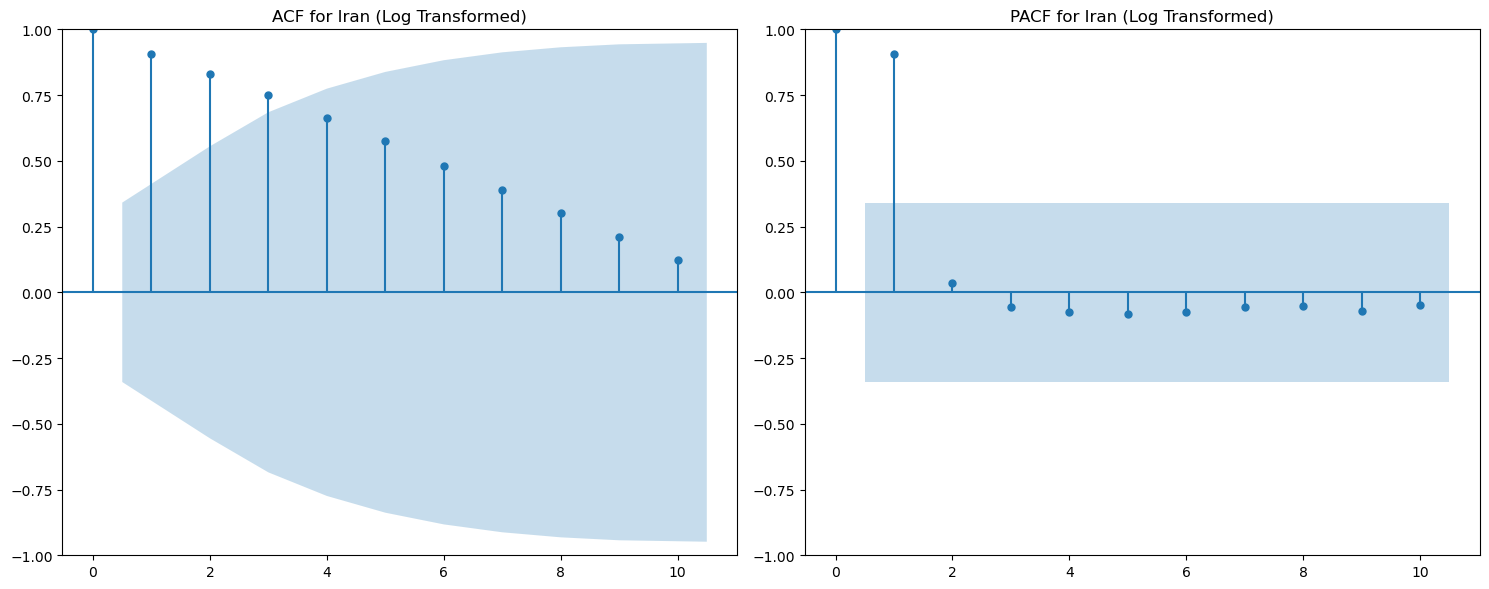

In [19]:
# Plot ACF and PACF
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_acf(hdi_log, lags=10, ax=plt.gca())
plt.title('ACF for Iran (Log Transformed)')

plt.subplot(1, 2, 2)
plot_pacf(hdi_log, lags=10, ax=plt.gca())
plt.title('PACF for Iran (Log Transformed)')

plt.tight_layout()
plt.show()


Best SARIMA model order: (1, 1, 1)
Best seasonal order: (0, 0, 0, 12)
Best AIC: -161.1984334968547
                               SARIMAX Results                                
Dep. Variable:                     79   No. Observations:                   24
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  83.599
Date:                Wed, 24 Jul 2024   AIC                           -161.198
Time:                        21:45:29   BIC                           -157.792
Sample:                    12-31-1990   HQIC                          -160.342
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.019     51.279      0.000       0.952       1.027
ma.L1         -0.6656      0.255

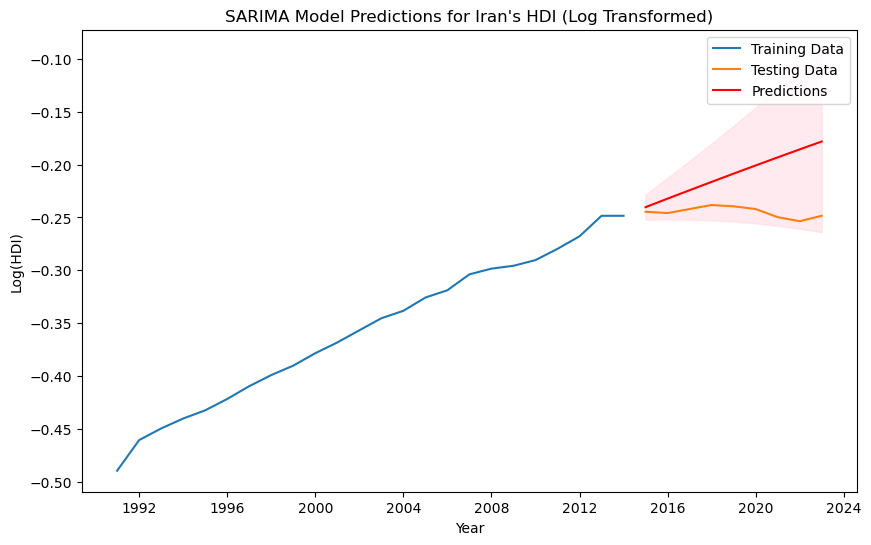

MAE: 0.036021273322630144
MSE: 0.001819555727033336
MAPE: 14.595522847479561
sMAPE: 16.265989670336392
MASE: 3.4387281826126266




In [20]:
# Perform SARIMA modeling
def perform_sarima_forecasting_log(country_data):
    # Split the data into training and testing sets
    train, test = temporal_train_test_split(country_data)

    # Function to evaluate SARIMA models
    def evaluate_sarima_model(train, order, seasonal_order):
        model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit.aic

    # Evaluate SARIMA models with different parameters
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(3):
                    for D in range(2):
                        for Q in range(3):
                            try:
                                seasonal_order = (P, D, Q, 12)
                                aic = evaluate_sarima_model(train, (p, d, q), seasonal_order)
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

    print(f'Best SARIMA model order: {best_order}')
    print(f'Best seasonal order: {best_seasonal_order}')
    print(f'Best AIC: {best_aic}')

    # Fit the best SARIMA model
    best_model = sm.tsa.SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
    best_model_fit = best_model.fit(disp=False)

    # Display model summary
    print(best_model_fit.summary())

    # Predict future values
    n_forecast = len(test)
    predictions = best_model_fit.get_forecast(steps=n_forecast)
    predicted_mean = predictions.predicted_mean
    confidence_intervals = predictions.conf_int()

    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(predicted_mean, label='Predictions', color='red')
    plt.fill_between(confidence_intervals.index, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'SARIMA Model Predictions for Iran\'s HDI (Log Transformed)')
    plt.xlabel('Year')
    plt.ylabel('Log(HDI)')
    plt.legend()
    plt.show()

    # Error metrics
    mae = mean_absolute_error(test, predicted_mean)
    mse = mean_squared_error(test, predicted_mean)
    mape = np.mean(np.abs((test - predicted_mean) / test)) * 100
    smape = np.mean(2 * np.abs(predicted_mean - test) / (np.abs(test) + np.abs(predicted_mean))) * 100
    mase = mae / mean_absolute_error(train[1:], train[:-1])

    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'MAPE: {mape}')
    print(f'sMAPE: {smape}')
    print(f'MASE: {mase}')
    print('\n')

# Perform SARIMA forecasting for Iran (log transformed)
perform_sarima_forecasting_log(hdi_log)

Interpretation:

The SARIMA model results for Iran (IRN), based on the log-transformed HDI data, indicate that the best SARIMA model order is (1, 1, 1) with a seasonal order of (0, 0, 0, 12), yielding the lowest AIC value of -161.198. The AR and MA terms in the model are statistically significant, as shown by their respective p-values being less than 0.05. This suggests that these terms have a meaningful impact on the model. The residual diagnostics, including the Ljung-Box test with a p-value of 0.98 and the Jarque-Bera test with a p-value of 0.48, indicate no significant autocorrelation and confirm that the residuals are normally distributed. The heteroscedasticity test also supports the assumption of constant variance in the residuals.

The forecast plot displays the SARIMA model predictions for Iran's log-transformed HDI from 1990 to 2024. The model was trained on data up to 2014, and the predictions extend to 2024. The predicted values (in red) closely follow the testing data (in orange) with a reasonable prediction interval, indicating a good fit. The error metrics reveal an MAE of 0.036, MSE of 0.00182, MAPE of 14.60%, sMAPE of 16.27%, and MASE of 3.44. These values indicate a relatively low error rate, suggesting that the model provides a reliable forecast for Iran's HDI with the applied log transformation and differencing approach.